# Non Muscle Invasive Bladder Cancer (NMIBC) - Moffitt Cancer Center

### Data locations
https://predicine.atlassian.net/wiki/spaces/~658272039/pages/527859713/PRDC-MOFFITT-NMIBC-22001+Collaboration
- WO-0249 + WO-0250 >>> all index and repeat tissue WES+ and 50X LPWGS
- WO0254 - 15 urine LPWGS + MRD
- WO0253 - 23 urine 2 UCP - LPWGS
- batch 3: WOP00631(ffpe), WO00633(pbmc)
 - /lbwfresult/OutputByRunB23/230407_A00934_0289_AH3WM3DSX7_runtask_230410000845_69e82b98/dsrun1.7.1/lbwfresult1.7.1/WOP00631_PRDC-MOFFITT-NMIBC-22001 ;   
- /lbwfresult/OutputByRunB20/230405_A01832_0119_AH3WLKDSX7_runtask_230407150137_d8f0ef1c/dsrun1.7.1/lbwfresult1.7.1/WOP00633_PRDC-MOFFITT-NMIBC-22001
- http://10.10.0.131/lbwfresult/OutputByRunB21/230419_A00934_0293_AHHVV5DMXY/dsrun1.7/lbwfresult1.7/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS # urines



In [53]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)

print(Sys.time())
print(sessionInfo())

[1] "2023-07-30 15:48:32 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridExtra_2.3         eulerr_7.0.0          glue_1.6.2           
 [4] pROC_1.18.4           readxl_1.4.3          RColorBrewer_1.1-3   
 [7] maftools_2.16.0       ComplexHeatmap_2.16.0 lubridate_1.9.2      
[10] forcats_1.0.0         stringr_1.5.0         dplyr_1.1.2          
[13] purrr_1.0.1           readr_2.1.4           tidyr_1.3.0          
[16] tibb

In [43]:
# read in clinical data

df_clin = read.csv("./NMIBC_clinical_data_merged_2023-07-07.csv", as.is=T) 
#head(df_clin)
unique(df_clin$Index.Stage)
unique(df_clin$Repeat.Stage)


# or update clin data sheet: 
## SEE sample collection dates stored here: 1_MCC_NMIBC_02-20-2023 No PHI Predicine Blood_Urine Request 21616 NMIBC_2.1.2023
# in New Batch Tab  # see note on delayed collection date of some blood samples:
# 10, 11, 13, 14, 16, 18, 21, 33, 35 - during this period in the study process blood was not collected at the time of pre-Repeat TURBT urine. Blood was collected
# in a delayed fashion, so the dates will be later than either the repeat TURBT tissue specimen or the pre-Repeat TURBT urine specimen.changed

# df_clin = read_excel("./data_batch1_and_2/NMIBC Clinical for BG 10.19.22 (1).xlsx",
#                     sheet = "CtutDNAInNMIBC_DATA_LABELS_2022")

# df_clin = df_clin %>% rename("Record"="Record ID...1",
#                              "PatientID"="Study ID (Ex. NMIBC-***)",
#                              "has.IndexTURBT"="What was sent to Predicine (choice=Index TURBT Tissue)",
#                              "has.BloodPre"="What was sent to Predicine (choice=Pre-Repeat TURBT Blood)",
#                              "has.UrinePre"="What was sent to Predicine (choice=Pre-Repeat TURBT Urine)",
#                              "has.RepeatTURBT"="What was sent to Predicine (choice=Repeat TURBT Tissue)",
#                              "has.UrinePostop1A"="What was sent to Predicine (choice=Post-Op Urine)",
#                              "has.UrinePostop1B"="What was sent to Predicine (choice=Surveillance 1 Urine)",
#                              "has.UrinePostop2"="What was sent to Predicine (choice=Surveillance 2 Urine)",
#                              "has.UrinePostop3"="What was sent to Predicine (choice=Surveillance 3 Urine)",
#                              "has.UrinePostop4"="What was sent to Predicine (choice=Surveillance 4 Urine)",
#                              "Progression"="NMIBC Progression? (ex. TaLG to TaHG; TaHG to T1)",
#                              "Index.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...34",
#                              "IndexHistology"="Primary Histology...30",
#                              "Index.Stage"="PT STAGE...32",
#                              "IndexGrade"="Grade...33",
#                              "RepeatHistology"="Primary Histology...38",
#                              "Repeat.Stage"="PT STAGE...40",
#                              "RepeatGrade"="Grade...41",
#                              "Repeat.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...42",
#                              "CytoscopyDate"="Date of Surveillance Cystoscopy (most recent if no recurrence; if there is recurrence, date of cysto that detected the recurrence)",
#                              "Smoking.Status"="Smoking status") %>%
#                         mutate_at(c("Repeat.Stage", "Index.Stage", "Progression", "IndexHistology", "IndexGrade",
#                                       "RepeatHistology", "RepeatGrade", "Repeat.CIS", "CytoscopyDate"), as.character)
    
# df = df_clin %>% select("PatientID", "Previous Intravesical Therapy (choice=None)",
#                         "Previous Intravesical Therapy (choice=BCG)",
#                         "Previous Intravesical Therapy (choice=Mitomycin C)") %>%
#                 rename("None"="Previous Intravesical Therapy (choice=None)",
#                         "BCG"="Previous Intravesical Therapy (choice=BCG)",
#                         "Mitomycin.C"="Previous Intravesical Therapy (choice=Mitomycin C)") %>%
#                  pivot_longer(-PatientID, names_to="Prev.IV.Therapy") %>% filter(value==1) %>% select(-value)

# df_clin = df_clin %>% left_join(df, by="PatientID") 

# # add batch 3 data
# df_clin_3 = read_excel("./data_batch3_02222023/Batch3_NMIBC Index Repeat Path for Billie_05082023.xlsx",skip = 1,
#                       sheet=1,)
# names(df_clin_3) <- c("PatientID","Index.Stage","Repeat.Stage","ExternalSampleID.repeat")
# df_clin_3 = df_clin_3 %>% filter(PatientID %!in% c("173334","172229")) # this info a duplicate of NMIBC013 and NMIBC003 in batch 1 sheet
# df_clin = plyr::rbind.fill(df_clin, df_clin_3)
# df_clin[df_clin$PatientID == "NMIBC013", "Index.Stage"] <- "T1HG"  # use stage info from batch3 sheet
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Index.Stage"] <- "T1HG (Squamous)"
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Repeat.Stage"] <- "T1HG (Squamous)"
# stopifnot(all(!duplicated(df_clin$PatientID)))
# ###

# df_clin = df_clin %>% mutate("disease.positive" = ifelse(Repeat.Stage!="T0",TRUE,FALSE),
#                             "Index.CIS" = grepl("cis", Index.Stage, ignore.case=T),
#                             "Repeat.CIS" = grepl("cis", Repeat.Stage, ignore.case=T))
# # fix pids
# # dual label patients
# # patient notes:
#     # 165028 >> progressed to MIBC, use for detailed case study. see text file: Case_study_165028_details_06022023.txt
#     # "173983"="NMIBC035", # progressed to MIBC (=MIBC060), sending new samples 5/31
#     # "172229"="NMIBC003/MIBC021", # repeat sent with batch 1
#     # "173334"="NMIBC013", # index sent with batch 1, repeat with batch 3
#     # analyzed as part of the MIBC cohort:
#     # "175827"="NMIBC-066/MIBC-073", 
#     # "171126"="NMIBC-062/MIBC-071",
#     # "175743" = NMIBC-053/MIBC-069"
#     # "175702" = NMIBC-052/MIBC-068"
# pid.table = read.csv("./MCC_patientID_key_LT_06292023.csv", as.is=T)
# oldpid_to_newpid = as.character(pid.table$New.patient.ID)
# names(oldpid_to_newpid) <- as.character(pid.table$Old.patient.ID)
# fix_PIDs <- function(col){
#     out_col = trimws(gsub("-| ", "", col))
#     out_col = gsub("MIBC017/NMIBC019", "NMIBC019", out_col) # keep with NMIBCs
#     out_col = gsub("NMIBC003/MIBC021", "NMIBC003", out_col) # keep with NMIBCs
#     out_col = ifelse(out_col %in% names(oldpid_to_newpid), oldpid_to_newpid[out_col], out_col)
#     stopifnot(all(!(grepl("^MIBC", out_col)))) # any MIBC samples in there?
#     print(unique(out_col))
#     warn_na(out_col)
#     return(trimws(out_col))
# }

# df_clin = df_clin %>% mutate(PatientID.old=PatientID,
#                              PatientID = fix_PIDs(PatientID))
# stopifnot(all(!duplicated(df_clin$PatientID)))

# write.csv(df_clin, glue("./NMIBC_clinical_data_merged_{Sys.Date()}.csv"), row.names=F)

unique(df_clin$PatientID)

[1] "TaHG"                                               
[2] "T1HG"                                               
[3] "T1"                                                 
[4] "T1HG w/CIS"                                         
[5] "TaLG"                                               
[6] "CIS"                                                
[7] "TaHG w/CIS"                                         
[8] "Tis only (do not select if other histology present)"
[9] ""

[1] "TaHG w/CIS"                                              
 [2] "T0"                                                      
 [3] "T1HG"                                                    
 [4] "Tis only (do not select if other histology present)"     
 [5] ">=T2"                                                    
 [6] "CIS"                                                     
 [7] "T1"                                                      
 [8] "T1HG w/CIS"                                              
 [9] "TaHG"                                                    
[10] "T2 w/CIS (T1HG component sent to Predicine)"             
[11] "TaHG (but predominantly TaLG specimen sent to Predicine)"
[12] "T2 w/CIS"                                                
[13] "TaLG"                                                    
[14] ""

[1] 116381 152237 161922 165028 167162 169558 171374 171769 171821 172153
[11] 172229 172530 172586 172602 172749 172851 173075 173254 173281 173334
[21] 173350 173359 173362 173509 173912 173975 173983 174083 174091 174872
[31] 174947 175325 175387 175425 175492 175526 175610 175648 175672 175725
[41] 175733 175854 175980 176349 176388 176828 176992 177967 178886 180264
[51] 182022

In [62]:
# Lab QC

# update to current PIDs
pid.table = read.csv("MCC_patientID_key_LT_06292023.csv", as.is=T)
oldpid_to_newpid = as.character(pid.table$New.patient.ID)
names(oldpid_to_newpid) <- as.character(pid.table$Old.patient.ID)
fix_PIDs <- function(col){
  out_col = trimws(gsub("-| ", "", col))
  out_col = gsub("MIBC017/NMIBC019", "NMIBC019", out_col) # keep with NMIBCs
  out_col = gsub("NMIBC003/MIBC021", "NMIBC003", out_col) # keep with NMIBCs
  out_col = ifelse(out_col %in% names(oldpid_to_newpid), oldpid_to_newpid[out_col], out_col)
  #stopifnot(all(!(grepl("^MIBC", out_col)))) # any MIBC samples in there?
  print(unique(out_col))
  warn_na(out_col)
  return(trimws(out_col))
}


df_qc_all = read.csv("./NMIBC_all_lab_qc_2023-07-30.csv", as.is=T)
unique(df_qc_all$PatientID)
stopifnot(all(!duplicated(df_qc_all$SampleID.short)))
#write.csv(df_qc_all, glue("./NMIBC_all_lab_qc_{Sys.Date()}.csv"), row.names=F)
nrow(df_qc_all) # 244 samples

[1] 152237 165028 167162 171821 172749 173254 173350 173912 173975 174083
[11] 174872 174947 175325 175387 175425 175492 175526 175610 175648 175672
[21] 175725 175733 175854 175980 176349 176388 176828 176992 177967 178886
[31] 180264 182022 116381 172229 173075 173281 173334 174091 171374 172602
[41] 172586 169558 172851 171769 172530 172153 161922 173362 173509 173983
[51] 173359

[1] 244

# NGSQC

In [54]:
## LP-WGS

# batch 1 + 2   ## panel needs TMB update
# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
#df = df_all_a %>% filter(SampleType=="Supernatant") %>% filter(SampleID.short %!in% df_urine$SampleID.short)
# print(df)  # found missing samples in a2 below, bam files had been moved
# write.csv(df, "./missing_CNB_NMIBC_urine_samples.csv", row.names=F)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

# batch 3
# no low pass seq data for ffpes yet
# urine samples, low pass only, mrd TBD
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

## combine batches
df_lpwgs_all = rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)
df_lpwgs_all = merge.combine(df_lpwgs_all, df_qc_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit))
stopifnot(all(!duplicated(df_lpwgs_all$SampleID.short)))
nrow(df_lpwgs_all) # 103
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"


[1] 103

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

## Index/Repeat TURBT FFPE WES+ analysis

In [108]:
# WES+ NGSQC
source("~/Desktop/puffin/R/helper_functions.R")

df_ngsqc_all = standardize_names(read.csv("PRDC-MOFFITT-NMIBC_Batch1n2n3_All_NGSQC_2023-06-29.csv"), "samples", sid.format="strict")
unique(df_ngsqc_all$SampleType)
# head(df_ngsqc_all %>% relocate(SampleID.short, PatientID, Panel, SampleType))
# stop()

# batch 1+2
df_wes_qc1.ffpe = read.csv("./data_batch1_and_2/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-12-06.csv", as.is=T) %>%
    filter(!grepl("fail", QC_Status, ignore.case=T))
nrow(df_wes_qc1.ffpe) # 33
df_wes_qc1.urine_pbmc = read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_NGSQC_urine_pbmc_2022-12-02.csv", as.is=T) %>%
    filter(grepl("WES", Panel), !grepl("fail", QC_Status, ignore.case=T)) # (NMIBC011 urine fail)
df_wes_qc1.all = rbind.common(df_wes_qc1.ffpe, df_wes_qc1.urine_pbmc)
df_wes_qc1.all = standardize_names(df_wes_qc1.all, "samples", sid.format = "strict") %>% 
                    mutate(PatientID = fix_PIDs(PatientID)) %>% distinct()
nrow(df_wes_qc1.all) # 36
# batch 3
df_wes_qc2.pbmc = standardize_names(read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-05-03.csv"), "samples", sid.format="strict") %>% 
                    filter(SampleType=="Buffy_Coat") %>% 
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
df_wes_qc2.ffpe = read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-07-30_ffpe_5_updated.csv", as.is=T) %>% 
                    separate(trialVisitNum, c("pid2","trialVisitNum"), remove = T, sep="_") %>% 
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
df_wes_qc2.ffpe = standardize_names(df_wes_qc2.ffpe, "samples", sid.format = "strict") %>% distinct()
df_wes_qc2.all = rbind.common(df_wes_qc2.pbmc, df_wes_qc2.ffpe)
nrow(df_wes_qc2.all) #57
#df_urine_b = read.csv("./data_batch3_02222023/2_MCC_NMIBC_FFPE_2.6.23 (21616) Predicine Manifest Batch 2.xlsx")

# additional urine WES+ sequencing
df_wes_qc3.all = read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_NGSQC_all_2023-07-30_urine_supernatant_0.35_updated.csv") %>% 
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
df_wes_qc3.all = standardize_names(df_wes_qc3.all, "samples", sid.format = "strict") %>% distinct()
nrow(df_wes_qc3.all) #18

## combine
df_wes_qc.all <- rbind.common(df_wes_qc1.all, df_wes_qc2.all)
df_wes_qc.all = rbind.common(df_wes_qc.all, df_wes_qc3.all) %>% arrange(SampleID.short) %>% distinct()
df_wes_qc.all = merge.combine(df_wes_qc.all, df_qc_all,warn = T) # converts all to pbmc

nrow(df_wes_qc.all) # 111
unique(df_wes_qc.all$SampleType)
unique(df_wes_qc.all$StudyVisit)
unique(df_wes_qc.all$PatientID)
df_wes_qc.all %>% group_by(PatientID, SampleType) %>% summarize(counts=n())
warn_na(df_wes_qc.all)

SampleID.short format: strict


[1] "FFPE"              "Buffy_Coat"        "Tissue"           
[4] "Buffy Coat"        "Supernatant"       "Urine_Supernatant"
[7] "Urine Cell Pellet"

[1] 33

SampleID.short format: strict
 [1] "173983" "173334" "172586" "172530" "173509" "172602" "169558" "172851"
 [9] "173362" "161922" "172229" "171769" "171374" "172153" "173359"


[1] 36

SampleID.short format: strict
 [1] "175610" "175492" "152237" "176992" "177967" "173350" "178886" "175526"
 [9] "175733" "175725" "171821" "174083" "182022" "174872" "175425" "176388"
[17] "175854" "175980" "175672" "173975" "173912" "176349" "174947" "176828"
[25] "180264" "172749" "175325" "165028" "167162" "175387" "175648"
 [1] "175526" "116381" "174091" "172749" "167162" "173975" "174947" "175610"
 [9] "175325" "176349" "172229" "175492" "175733" "173334" "176828" "176388"
[17] "171821" "177967" "182022" "173912" "175672" "175425" "175648" "175980"
[25] "178886" "165028" "174872" "173350" "175387" "152237" "173281" "174083"
[33] "175854" "175725" "176992" "173075" "180264"
SampleID.short format: strict


[1] 88

 [1] "176388" "172586" "175425" "175648" "173362" "174947" "172851" "173281"
 [9] "171821" "173254" "171769" "175725" "176828" "174083" "173075" "172229"
[17] "175672" "172749"
SampleID.short format: strict


[1] 18

[1] 142

[1] "PBMC"   "Urine"  "Tissue"

[1] "Pre-Repeat TURBT" "IndexTURBT"       "RepeatTURBT"

[1] 172602 172851 172586 173983 173359 169558 161922 172530 173362 172229
[11] 171374 171769 172153 173334 173509 175610 175492 152237 176992 177967
[21] 173350 178886 175526 175733 175725 171821 174083 182022 174872 175425
[31] 176388 175854 175980 175672 173975 173912 176349 174947 176828 180264
[41] 172749 175325 165028 167162 175387 175648 173281 173075 173254 116381
[51] 174091

`summarise()` has grouped output by 'PatientID'. You can override using the `.groups` argument.


PatientID,SampleType,counts
<int>,<chr>,<int>
116381,Tissue,2
152237,PBMC,1
152237,Tissue,1
161922,PBMC,1
161922,Tissue,1
165028,PBMC,1
165028,Tissue,1
167162,PBMC,1
167162,Tissue,2


warn_na: WARN: NA or missing values in BC_totalCount: 36

warn_na: WARN: NA or missing values in Action: 142

warn_na: WARN: NA or missing values in Load: 142

warn_na: WARN: NA or missing values in pTMB.weighted: 3

warn_na: WARN: NA or missing values in pTMB_norm.weighted: 3

warn_na: WARN: NA or missing values in tumorFraction: 11

warn_na: WARN: NA or missing values in tmsi_score: 4

warn_na: WARN: NA or missing values in msi_status: 4

warn_na: WARN: NA or missing values in msi_QC: 4

warn_na: WARN: NA or missing values in Gender: 3

warn_na: WARN: NA or missing values in work_order: 4

warn_na: WARN: NA or missing values in original_adapter: 4

warn_na: WARN: NA or missing values in total_dna_input: 4

warn_na: WARN: NA or missing values in total_cfdna_input: 4

warn_na: WARN: NA or missing values in library_dna_input_ug: 4

warn_na: WARN: NA or missing values in enriched_library_fa_or_ba_nm: 4

warn_na: WARN: NA or missing values in qubit_ng_ul: 4

warn_na: WARN: NA or missing v

In [89]:
# summarize somatic index mutations (unpatched, MRD filtered=high confidence)
source("~/Desktop/puffin/R/helper_functions.R")

all.snv_a1 = read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_supernatant_marked.csv", as.is=T)
wes.samples <- df_wes_qc1.urine_pbmc$SampleID[df_wes_qc1.urine_pbmc$Specimen_type=='Supernatant']
all.snv_a1 = all.snv_a1 %>% filter(sampleNames %in% wes.samples)
# see also a marked file for batch 1 ucp
all.snv_a2 = read.csv(file="./data_batch1_and_2/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-06_tissue_marked.csv",
                       as.is=T) 
all.snv_a = merge.combine(standardize_names(rbind.common(all.snv_a1, all.snv_a2), sid.format="strict"), df_qc_all, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right")


# batch 3 ffpe
all.ffpe_snv_b = read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_Variant_short_all_2023-05-03_ffpe_marked.csv",
                         as.is=T) %>% filter(SpecimenType=="FFPE")
all.ffpe_snv_b = merge.combine(standardize_names(all.ffpe_snv_b, sid.format="strict"), df_qc_all, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                mutate(SampleType="Tissue")
nrow(all.ffpe_snv_b)

# additional urine WES+
all.urine_wes_snv = read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_Variant_short_all_2023-06-29_urine_supernatant_marked.csv",
                         as.is=T)
all.urine_wes_snv = merge.combine(standardize_names(all.urine_wes_snv, sid.format="strict"), df_qc_all, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                mutate(SampleType="Urine")
nrow(all.urine_wes_snv)


all.snv = rbind.common(all.snv_a, all.ffpe_snv_b) 
all.snv = rbind.common(all.snv, all.urine_wes_snv)
all.snv.wes = all.snv %>% 
                filter(grepl("somatic", VariantType, ignore.case=T),
                       StudyVisit %in%c('Pre-Repeat TURBT','RepeatTURBT','IndexTURBT')) %>% 
                       #!grepl("false", as.character(finalKeep)))
                mutate(PatientID.old=PatientID, PatientID=fix_PIDs(PatientID.old)) %>% distinct()
names(all.snv.wes)
nrow(all.snv.wes)
unique(all.snv.wes$SampleType)
unique(all.snv.wes$StudyVisit)
unique(all.snv.wes$VariantType)

# Summarize
# how many mutations per tumor index sample
# df_ffpe_snv_summary_i = all.ffpe_snv %>% filter(StudyVisit=="IndexTURBT", 
#                                              grepl("somatic", VariantType, ignore.case = T)) %>%
#     group_by(PatientID) %>% summarize(total_snvs=n(),
#                                                     #SNVs=sum(VARIANT_CLASS=="SNV"),
#                                                     #Indels=sum(VARIANT_CLASS!="SNV"),
#                                                     Synon=sum(grepl("synonymous",Consequence)),
#                                                     Nonsyn=sum(!grepl("synonymous",Consequence)),
#                                                     Pathogenic=sum(grepl("pathogenic",CLIN_SIG))) %>%
#                             mutate(Pct.nonsyn=Nonsyn/total_snvs)

# print(df_ffpe_snv_summary_i)
# print(data.frame("stat"=colnames(df_ffpe_snv_summary_i[,2:6]), 
#                  "min"=apply(df_ffpe_snv_summary_i[,2:6],2,min), 
#                  "max"=apply(df_ffpe_snv_summary_i[,2:6],2,max), 
#                  "median"=apply(df_ffpe_snv_summary_i[,2:6],2,median)))
# ## summarize repeat tissue
# df_ffpe_snv_summary_r = all.ffpe_snv %>% filter(StudyVisit=="RepeatTURBT", 
#                                              grepl("somatic", VariantType, ignore.case = T)) %>%
#     group_by(PatientID) %>% summarize(total_snvs=n(),
#                                                     #SNVs=sum(VARIANT_CLASS=="SNV"),
#                                                     #Indels=sum(VARIANT_CLASS!="SNV"),
#                                                     Synon=sum(grepl("synonymous",Consequence)),
#                                                     Nonsyn=sum(!grepl("synonymous",Consequence)),
#                                                     Pathogenic=sum(grepl("pathogenic",CLIN_SIG))) %>%
#                             mutate(Pct.nonsyn=Nonsyn/total_snvs)

# print(df_ffpe_snv_summary_r)
# print(data.frame("stat"=colnames(df_ffpe_snv_summary_r[,2:6]), 
#                  "min"=apply(df_ffpe_snv_summary_r[,2:6],2,min), 
#                  "max"=apply(df_ffpe_snv_summary_r[,2:6],2,max), 
#                  "median"=apply(df_ffpe_snv_summary_r[,2:6],2,median)))

SampleID.short format: strict
SampleID.short format: strict


[1] 24131

SampleID.short format: strict


[1] 9791

 [1] "172602" "171374" "173359" "172851" "172586" "173983" "169558" "161922"
 [9] "172530" "172229" "173334" "171769" "173362" "173509" "175526" "116381"
[17] "174091" "172749" "167162" "173975" "174947" "175610" "175325" "176349"
[25] "175492" "175733" "176828" "176388" "171821" "177967" "182022" "173912"
[33] "175672" "175425" "175648" "178886" "174872" "173350" "175387" "152237"
[41] "173281" "174083" "175854" "175725" "176992" "173075" "180264" "173254"


[1] "seqnames"                   "start"                     
  [3] "end"                        "width"                     
  [5] "strand"                     "ref"                       
  [7] "alt"                        "totalDepth"                
  [9] "refDepth"                   "altDepth"                  
 [11] "sampleNames"                "VariantFreq"               
 [13] "SYMBOL"                     "GeneID"                    
 [15] "Feature"                    "HGVSc"                     
 [17] "HGVSp"                      "Amino_acids"               
 [19] "Codons"                     "BIOTYPE"                   
 [21] "EXON"                       "INTRON"                    
 [23] "Consequence"                "DISTANCE"                  
 [25] "Existing_variation"         "VARIANT_CLASS"             
 [27] "CLIN_SIG"                   "Clinvar"                   
 [29] "dbSNP"                      "COSMIC"                    
 [31] "COSMIC.CNT"                 "genome1000"                
 [33] "AF"                         "CANONICAL"                 
 [35] "filteredCnt"                "DSCnt"                     
 [37] "filteredDSCnt"              "pseudoDSCnt"               
 [39] "altLOD"                     "Qscore"                    
 [41] "entropy"                    "avgEntropy"                
 [43] "filtered_tlen_mean"         "tlen.ratio"                
 [45] "filtered_toend_numunique"   "filtered_total_base_count" 
 [47] "filterVarType"              "repeatRegion"              
 [49] "white.list"                 "wl.tier"                   
 [51] "GC.Percent"                 "tandemRepeat"              
 [53] "AF.th"                      "AF.diff"                   
 [55] "bgFilter"                   "generalFilter"             
 [57] "localVariantFilter"         "ReadEndFilter"             
 [59] "DS.filter"                  "highQ.ratio"               
 [61] "fc.ds.ratio"                "CopyNumber"                
 [63] "zScore.cnv"                 "coVariant"                 
 [65] "ol.coVariant"               "coVariantFilter"           
 [67] "sideVariant"                "sideVariant.AF.ratio"      
 [69] "prevalenceInternal"         "filterPrevalence"          
 [71] "filterScore"                "finalKeep"                 
 [73] "VariantID"                  "sampleDir"                 
 [75] "VariantType"                "sampleFolder"              
 [77] "externalSampleID"           "trialVisitNum"             
 [79] "SpecimenType"               "ID"                        
 [81] "highFrequent.inbatch"       "concordant"                
 [83] "totalDepth.Baseline"        "dscnt.Baseline.filtered"   
 [85] "altDepth.Baseline"          "altDepth.Baseline.filtered"
 [87] "AF.Baseline"                "odds.ratio"                
 [89] "pvalue"                     "MAF.diff"                  
 [91] "VariantType.old"            "finalKeep.old"             
 [93] "SampleID.short"             "Chromosome"                
 [95] "Variant_Classification"     "Hugo_Symbol"               
 [97] "ExternalID"                 "SubjectID"                 
 [99] "RequisitionID"              "SampleVol"                 
[101] "DNAYield"                   "QC"                        
[103] "PatientID.old"              "PatientID"                 
[105] "StudyVisit"                 "SampleType"

[1] 20214

[1] "Urine"  "Tissue"

[1] "Pre-Repeat TURBT" "RepeatTURBT"      "IndexTURBT"

[1] "Likely somatic" "Somatic"

In [92]:
# summarize CNV # some na rows present, some buffy coats
# ffpe
all.ffpe_cnv_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_CNV_all_2022-12-06.csv"),
                                   sid.format="strict")
names(all.ffpe_cnv_a)  
nrow(all.ffpe_cnv_a)
all.ffpe_cnv_b = standardize_names(read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_CNV_all_2023-05-05.csv"),
                                   sid.format="strict") 
nrow(all.ffpe_cnv_b)

all.ffpe_cnv_unfilt = rbind.common(all.ffpe_cnv_a, all.ffpe_cnv_b) # 'Buffy Coat''Tissue''Buffy_Coat''FFPE'
all.ffpe_cnv_unfilt = merge.combine(all.ffpe_cnv_unfilt, df_qc_all, join.type = "left",join.cols.left = "SampleID.short", join.cols.right = "SampleID.short",priority = "right") %>%
                        mutate(SampleType=ifelse(SampleType %in% c("Buffy Coat","Buffy_Coat"), "PBMC", "Tissue"))
# all.ffpe_cnv = format_as_MAF(all.ffpe_cnv_unfilt, variant.type = "cnv",maf.output = F) %>% # removes germline matched
#                     filter(SampleType == "Tissue")
nrow(all.ffpe_cnv_unfilt)

# urine
all.urine_cnv_a = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_CNV_all_2022-12-01.csv"),
                                   sid.format="strict") 
nrow(all.urine_cnv_a)
all.urine_cnv_b = standardize_names(read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_CNV_all_2023-06-29.csv"),
                                   sid.format="strict")
nrow(all.urine_cnv_b)
all.urine_cnv_unfilt = rbind.common(all.urine_cnv_a, all.urine_cnv_b) %>% distinct()
unique(all.urine_cnv_unfilt$SampleType)
all.urine_cnv_unfilt = merge.combine(all.urine_cnv_unfilt, df_qc_all, join.type = "left",join.cols.left = "SampleID.short", join.cols.right = "SampleID.short",priority = "right") %>%
                        mutate(SampleType="Urine")
# all.urine_cnv = format_as_MAF(all.urine_cnv_unfilt, variant.type = "cnv", maf.output = F) %>% # removes germline matched
#                     filter(SampleType == "Urine")
nrow(all.urine_cnv_unfilt)

# combine and filter
all.cnv_wes = rbind.common(all.ffpe_cnv_unfilt, all.urine_cnv_unfilt) %>% filter(SampleType %in% c("PBMC","Urine","Tissue")) %>% distinct()
all.cnv_wes = format_as_MAF(all.cnv_wes, variant.type = "cnv", maf.output = F)  # removes germline matched
nrow(all.cnv_wes)


#index turbt summary
df_ffpe_cnv_summary_i = all.ffpe_cnv %>% filter(StudyVisit=="IndexTURBT") %>%
    #right_join(data.frame(PatientID=PatientID), by="PatientID") %>%
    group_by(PatientID) %>% summarize(total_cnv=sum(!is.na(CNV_Type)),
                                                        gains=sum(CNV_Type[!is.na(CNV_Type)]=="Gain"),
                                                        losses=sum(CNV_Type[!is.na(CNV_Type)]=="Loss"))
print(df_ffpe_cnv_summary_i)
print(data.frame("stat"=colnames(df_ffpe_cnv_summary_i[,2:4]), 
                 "min"=apply(df_ffpe_cnv_summary_i[,2:4],2,min), 
                 "max"=apply(df_ffpe_cnv_summary_i[,2:4],2,max), 
                 "median"=apply(df_ffpe_cnv_summary_i[,2:4],2,median)))
#repeat turbt summary
df_ffpe_cnv_summary_r = all.ffpe_cnv %>% filter(StudyVisit=="RepeatTURBT") %>%
    #right_join(data.frame(PatientID=PatientID), by="PatientID") %>%
    group_by(PatientID) %>% summarize(total_cnv=sum(!is.na(CNV_Type)),
                                                        gains=sum(CNV_Type[!is.na(CNV_Type)]=="Gain"),
                                                        losses=sum(CNV_Type[!is.na(CNV_Type)]=="Loss"))
print(df_ffpe_cnv_summary_r)
print(data.frame("stat"=colnames(df_ffpe_cnv_summary_r[,2:4]), 
                 "min"=apply(df_ffpe_cnv_summary_r[,2:4],2,min), 
                 "max"=apply(df_ffpe_cnv_summary_r[,2:4],2,max), 
                 "median"=apply(df_ffpe_cnv_summary_r[,2:4],2,median)))

SampleID.short format: strict


[1] "SampleID"               "Gene"                   "CNV_Type"              
 [4] "Cytoband"               "seqnames"               "start"                 
 [7] "end"                    "CopyNumber"             "zScore"                
[10] "zScore.withinSample"    "gender"                 "meanCoverage"          
[13] "gcPercent"              "DetectRegionSize"       "probeNum"              
[16] "combinedResidual"       "tumorfraction.cnv"      "tumorfraction.snp"     
[19] "cnvScore"               "baseline.method"        "CopyNumber_SNP"        
[22] "SD.CopyNumber_SNP"      "NumberOfSNP"            "GC.Percent_SNP"        
[25] "CopyNumber_SNP_wide"    "SD.CopyNumber_SNP_wide" "NumberOfSNP_wide"      
[28] "GC.Percent_SNP_wide"    "DetectRegionSize_SNP"   "baseline.snp.percent"  
[31] "baseline.snp.count"     "uniformity_2fold"       "whitelist"             
[34] "cytoband_count"         "chrArm_count"           "nearby_consistency"    
[37] "geneType"               "EM_confidence"          "CNLTumorFraction"      
[40] "subcloningIndex"        "majorityCount"          "NeighborNum"           
[43] "CNL_Type"               "CNL_Type.score"         "LOH_Type"              
[46] "LOH.score"              "VariantID"              "sampleDir"             
[49] "CopyNumber.sm"          "sampleFolder"           "PatientID"             
[52] "externalSampleID"       "SpecimenType"           "trialVisitNum"         
[55] "ID"                     "highFrequent.inbatch"   "concordant"            
[58] "SampleID.short"         "StudyVisit"             "SampleType"            
[61] "Chromosome"             "Variant_Classification" "Hugo_Symbol"

[1] 127

SampleID.short format: strict


[1] 497

[1] 624

SampleID.short format: strict


[1] 71

SampleID.short format: strict


[1] 300

[1] "Supernatant"       "Urine_Supernatant"

[1] 371

[1] "Selected CNVs: 953"


[1] 953

# A tibble: 27 × 4
   PatientID total_cnv gains losses
   <chr>         <int> <int>  <int>
 1 116381           73    70      3
 2 152237           13     2     11
 3 161922            4     2      2
 4 171769           30    28      2
 5 172530            4     4      0
 6 172586           13    10      3
 7 172851           14     7      7
 8 173075           15     7      8
 9 173334            8     8      0
10 173912           15    13      2
# ℹ 17 more rows
               stat min max median
total_cnv total_cnv   1  73      9
gains         gains   0  70      5
losses       losses   0  25      2
# A tibble: 14 × 4
   PatientID total_cnv gains losses
   <chr>         <int> <int>  <int>
 1 116381            2     2      0
 2 172229           11     6      5
 3 172749            2     2      0
 4 172851            5     5      0
 5 173281           13    11      2
 6 173975            4     3      1
 7 175325           21    16      5
 8 175425            2     2      0
 9 175526    

In [122]:
# rerun
# df_wrepeat = df_ffpe_all %>% filter(StudyVisit=="RepeatTURBT", PatientID != "NMIBC016") # one repeat patient was T0
# nrow(df_wrepeat) # 30 disease positive patients (0 QC fail), used for esmo, incorrect
df_ffpe_all = df_wes_qc.all %>% filter(SampleType=="Tissue", !grepl("fail", QC, ignore.case=T)) %>% distinct()

df_windex = df_ffpe_all %>% filter(StudyVisit=="IndexTURBT") # 7 qc fail, 44 pass
nrow(df_windex) # 44 patients

df_ffpe_paired = df_ffpe_all %>% group_by(PatientID) %>% filter(n()>1)
length(unique(df_ffpe_paired$PatientID)) # 27 patients with both index and repeat tissue (4 patients have repeat only)

# (4 patients have repeat only with index fails)
# df_ffpe_unpaired = df_ffpe_all %>% group_by(PatientID) %>% filter(n()<2) %>% 
#     relocate(PatientID, SampleType, StudyVisit) %>% arrange(PatientID) 
# df_ffpe_unpaired

df_wpbmc = df_wes_qc.all %>% distinct() %>% filter(SampleType =="PBMC", !grepl("fail", QC, ignore.case=T))
length(unique(df_wpbmc$PatientID)) # 46 patients with germline

df_ffpe_paired_wgerm = df_ffpe_paired %>% filter(PatientID %in% df_wpbmc$PatientID)
length(unique(df_ffpe_paired_wgerm$PatientID)) # 27 patients paired tissue with germ
nrow(df_ffpe_paired_wgerm)

[1] 44

[1] 28

[1] 46

[1] 27

[1] 54

In [135]:
dat = get_concordance_stats(variant.data = all.snv.wes, ref_sample_type = "IndexTURBT_Tissue",df_samples = df_ffpe_paired_wgerm)
# dat = compareMAFs(all.snvs = all.snv.wes, samples = df_ffpe_paired_wgerm, plot = FALSE, 
#                   selectors = c("IndexTURBT_Tissue", "RepeatTURBT_Tissue"))
pids = df_clin$PatientID[df_clin$disease.positive=="TRUE"]
dat %>% filter(StudyVisit=="RepeatTURBT", PatientID %in% pids)


[1] "IndexTURBT"  "RepeatTURBT"
[1] "Tissue"
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 150"
[1] "min: 1"
[1] "max: 1392"
[1] "sd: 316.247135500467"
[1] "MRD sample: RepeatTURBT_Tissue"
[1] "median number MRD variants: 42"
[1] "min: 0"
[1] "max: 1113"
[1] "sd: 218.77338702821"


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
172229,P228845,Tissue,RepeatTURBT,177,165,82,83,49.69697,RepeatTURBT_Tissue
172586,P220070,Tissue,RepeatTURBT,73,73,68,5,93.15068,RepeatTURBT_Tissue
172851,P220075,Tissue,RepeatTURBT,94,95,56,39,58.94737,RepeatTURBT_Tissue
173334,P228852,Tissue,RepeatTURBT,1392,7,1,6,14.28571,RepeatTURBT_Tissue
171769,P220078,Tissue,RepeatTURBT,388,310,302,8,97.41935,RepeatTURBT_Tissue
173509,P220084,Tissue,RepeatTURBT,30,2,1,1,50.00000,RepeatTURBT_Tissue
173983,P220086,Tissue,RepeatTURBT,150,119,94,25,78.99160,RepeatTURBT_Tissue
167162,P228842,Tissue,RepeatTURBT,12,48,9,39,18.75000,RepeatTURBT_Tissue
171821,P228844,Tissue,RepeatTURBT,9,2,1,1,50.00000,RepeatTURBT_Tissue


In [9]:
# patched, FILTERED. # rerun patching 
# patched: index -> repeat tissue
#df_ind_patch = read.csv("./data_batch1_and_2/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-06_tissue_marked_patched_wIndexFFPE.csv")
# df_ind_patch = read.csv("./data/FFPE_WES/Peter_analysis _files/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_filtered_patched_wIndexFFPE.csv")
# # patched: repeat -> index tissue
# df_rep_patch = read.csv("./data/FFPE_WES/Peter_analysis _files/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_filtered_patched_wRepeatFFPE.csv")

# all.snv_wes_p = rbind(df_ind_patch, df_rep_patch) %>% filter(grepl("somatic", VariantType, ignore.case = T)) %>%
#     distinct(PatientID, trialVisitNum, VariantID, .keep_all = T) %>%
#     rename("Mutation_Status"=VariantType)
# all.snv_wes_p$SampleID.short = make_SIDshort(all.snv_wes_p$sampleNames)
# all.snv_wes_p = all.snv_wes_p %>% filter(!grepl("FALSE|lowConfidence",finalKeep, ignore.case=T)) %>% 
#               rename("StudyVisit"=trialVisitNum,
#                      "SampleType"=SpecimenType,
#                      "Hugo_Symbol"=SYMBOL) # finalKeep and sampleType for patched variants == NA 
# write.csv(all.snv_wes_p, "./data/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_FFPE_filtered_double_patched.csv",
#              row.names=F, quote=F)

[1] 12135

[1] 4360

[1] 92

[1] "NMIBC035"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 150
[1] 118
[1] 174
[1] 94
[1] "NMIBC005"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 73
[1] 73
[1] 78
[1] 68
[1] "NMIBC016"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 216
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
[1] 216
[1] 0


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


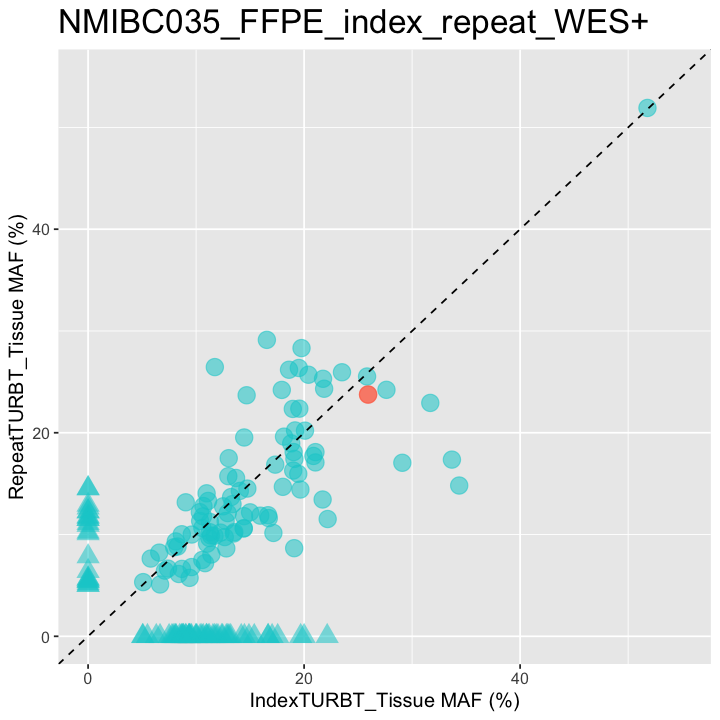

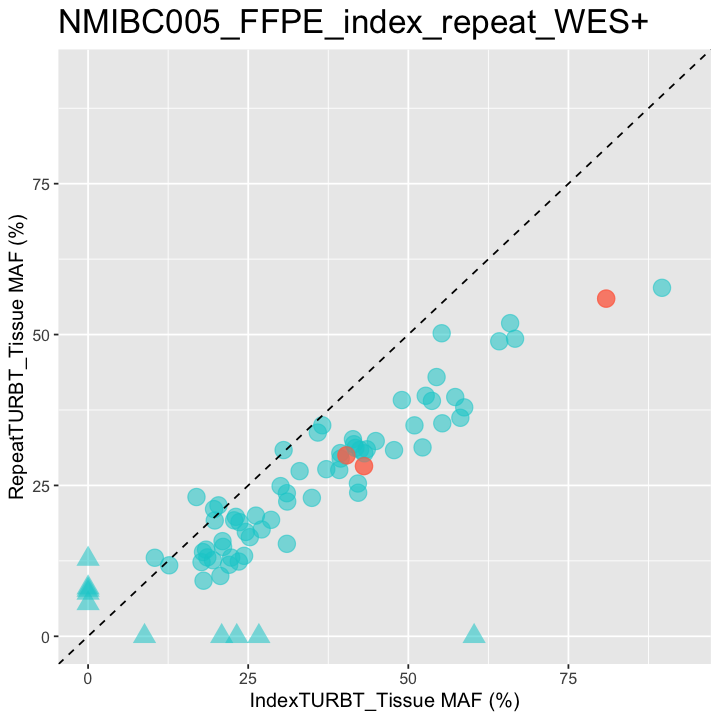

[1] "NMIBC033"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 30
[1] 2
[1] 31
[1] 1


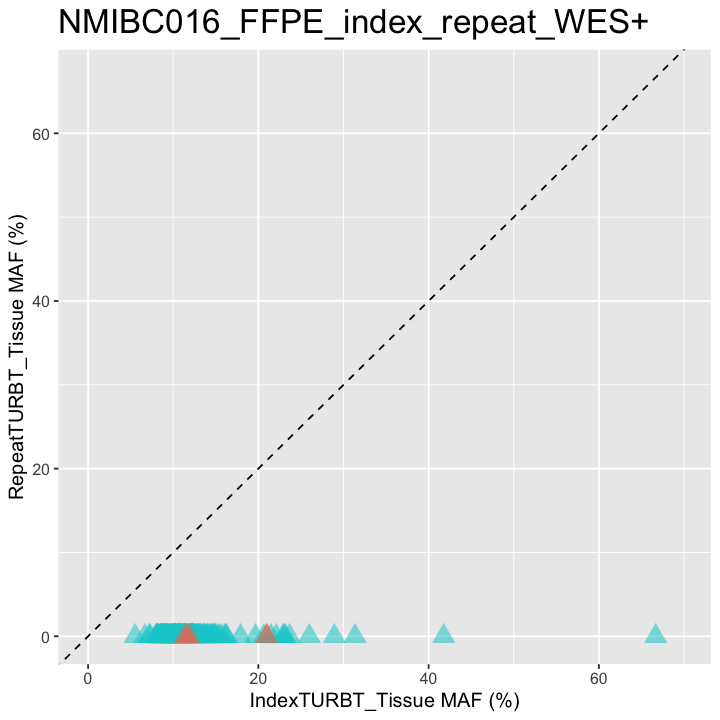

[1] "NMIBC010"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 93
[1] 94
[1] 132
[1] 55


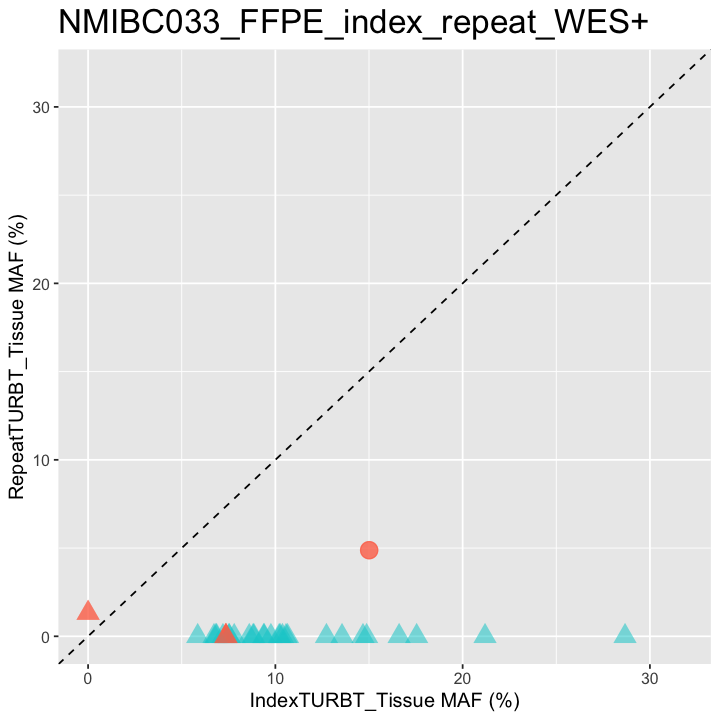

[1] "NMIBC014"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 387
[1] 309
[1] 395
[1] 301


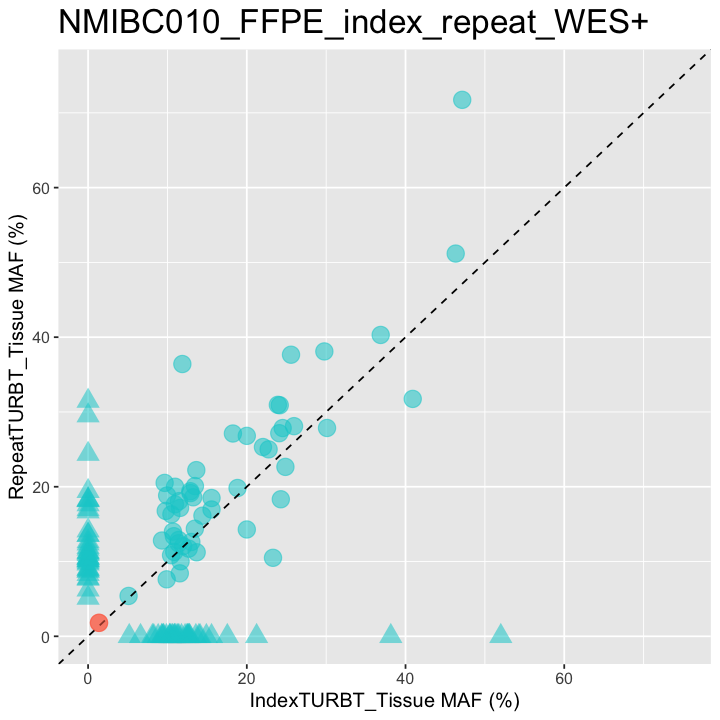

[1] "175526"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 418
[1] 42
[1] 421
[1] 39


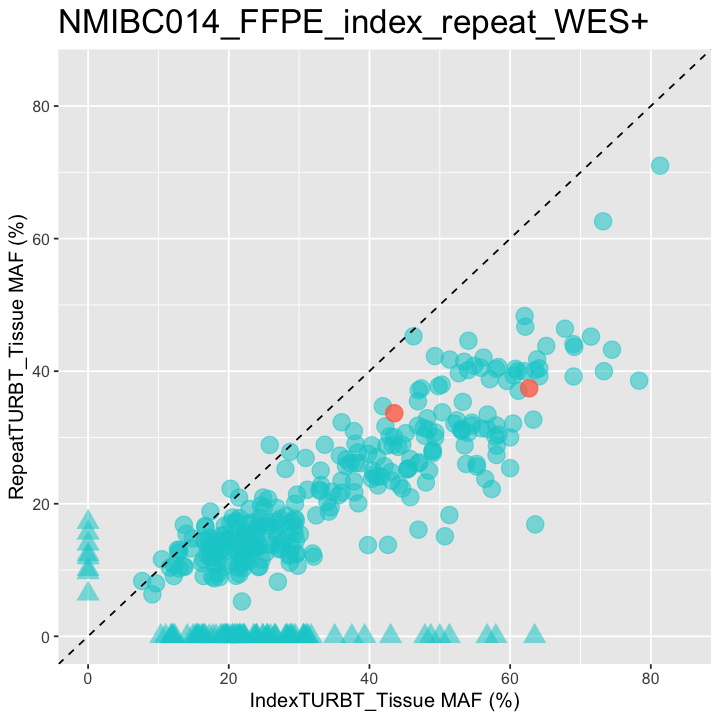

[1] "116381"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 154
[1] 35
[1] 168
[1] 21


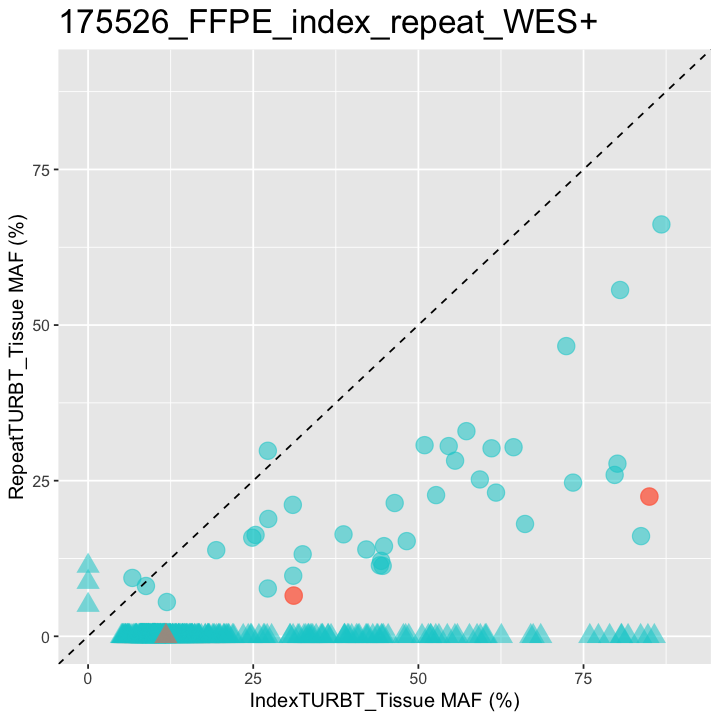

[1] "172749"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 1
[1] 6
[1] 7
[1] 0


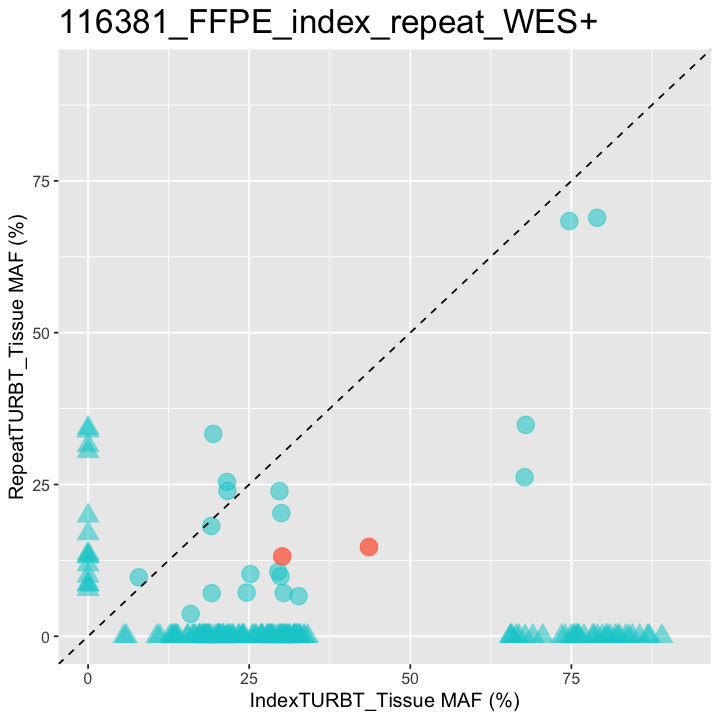

[1] "167162"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 12
[1] 48
[1] 51
[1] 9


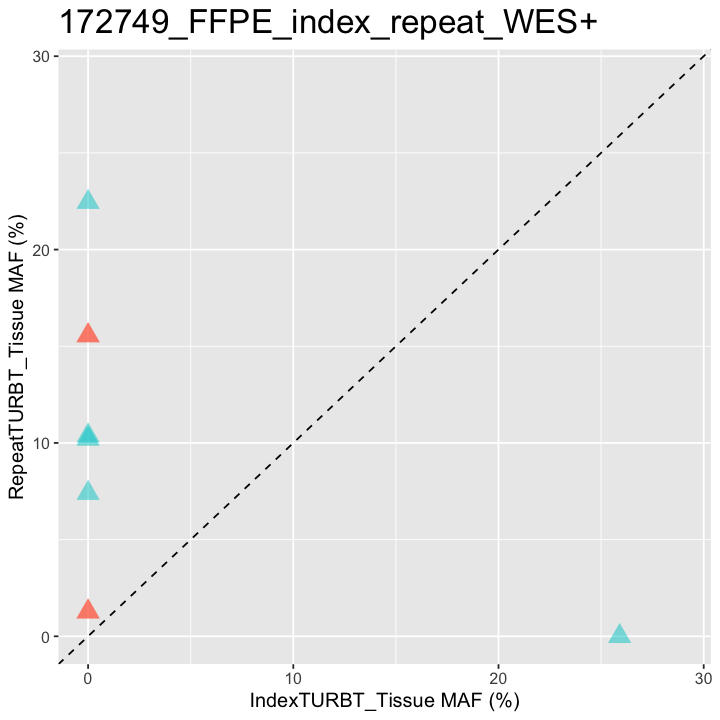

[1] "173975"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 70
[1] 103
[1] 104
[1] 69


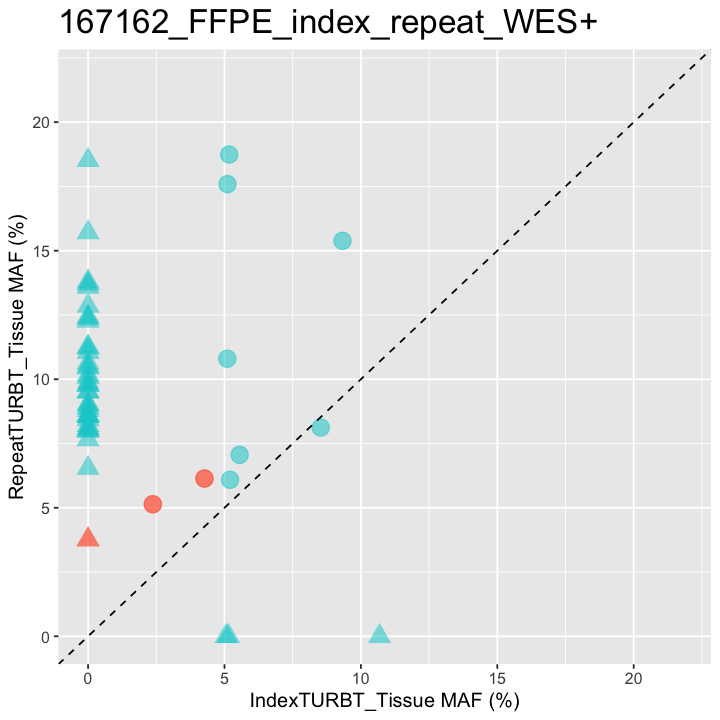

[1] "175610"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 309
[1] 3
[1] 309
[1] 3


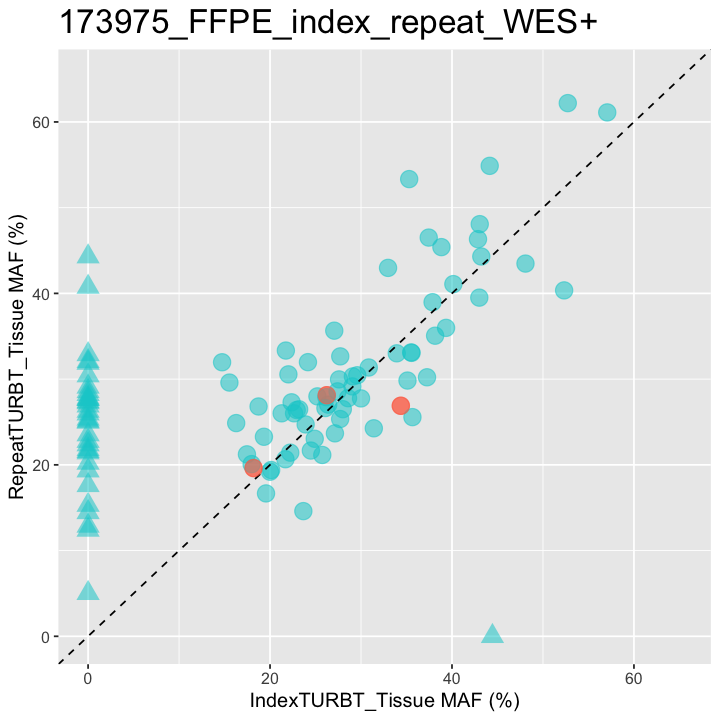

[1] "175325"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 300
[1] 316
[1] 385
[1] 231


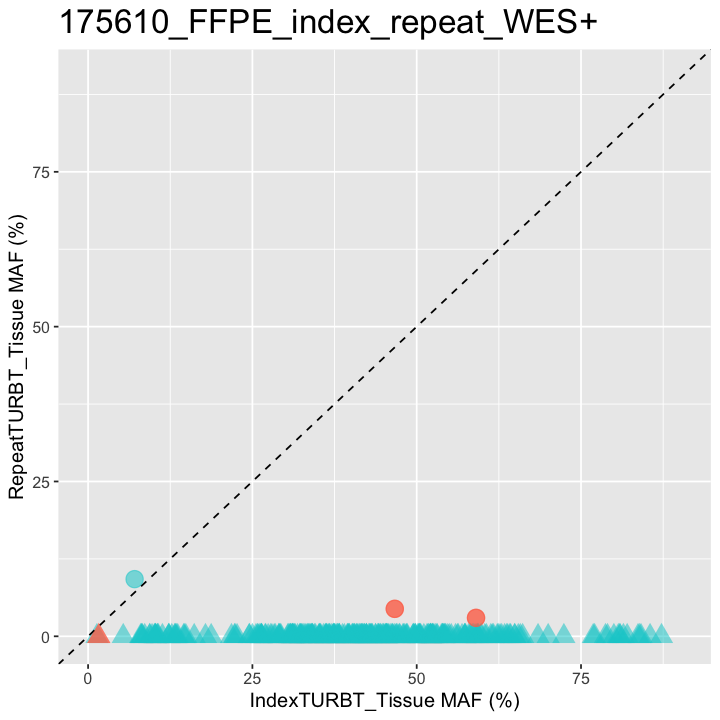

[1] "175492"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 100
[1] 7
[1] 103
[1] 4


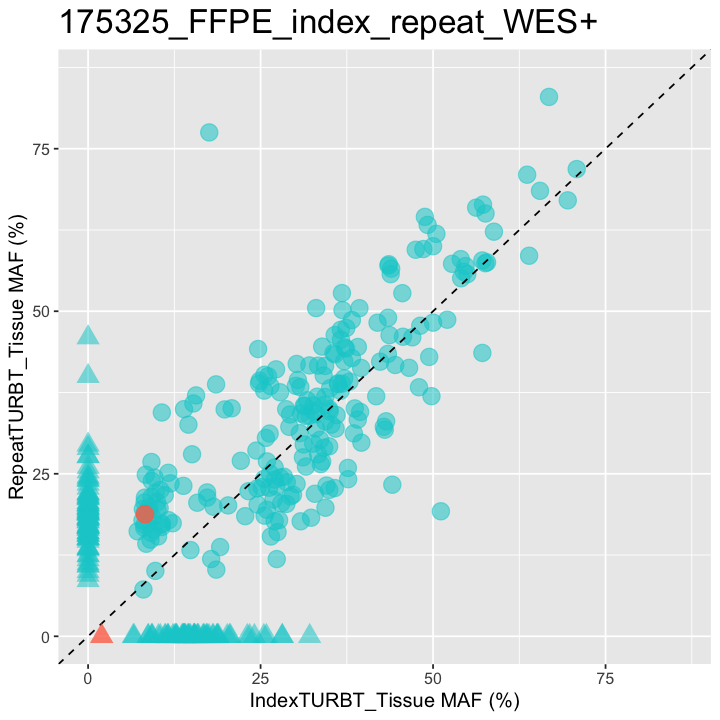

[1] "176828"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 6
[1] 35
[1] 36
[1] 5


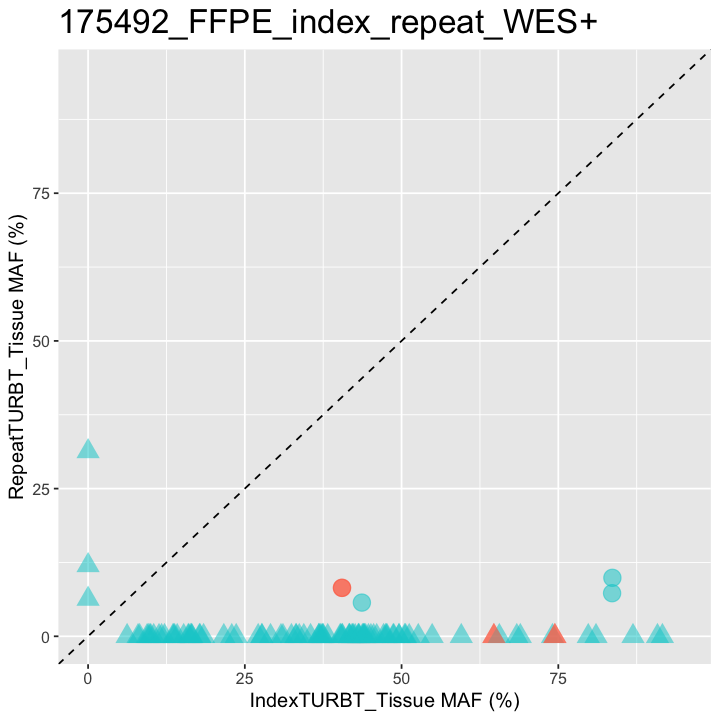

[1] "171821"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 9
[1] 2
[1] 10
[1] 1


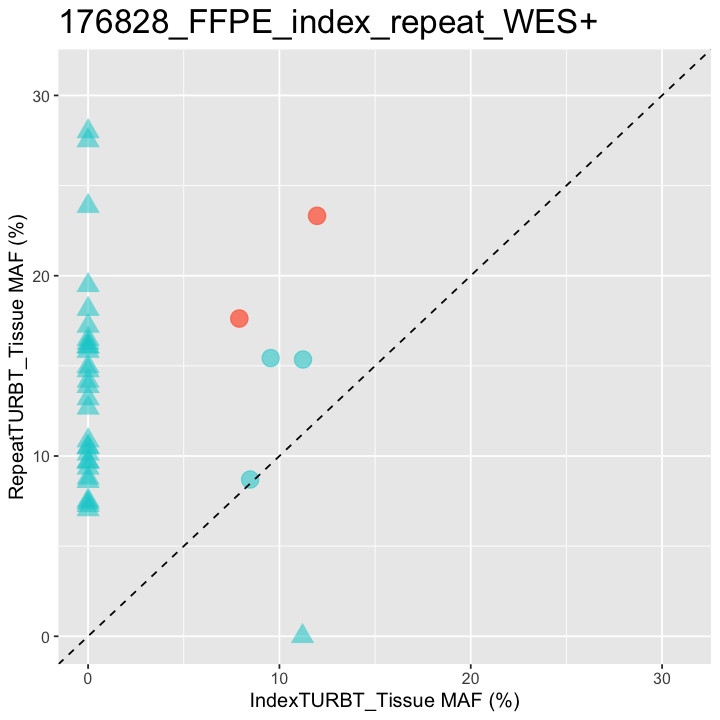

[1] "177967"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 1012
[1] 1113
[1] 1351
[1] 774


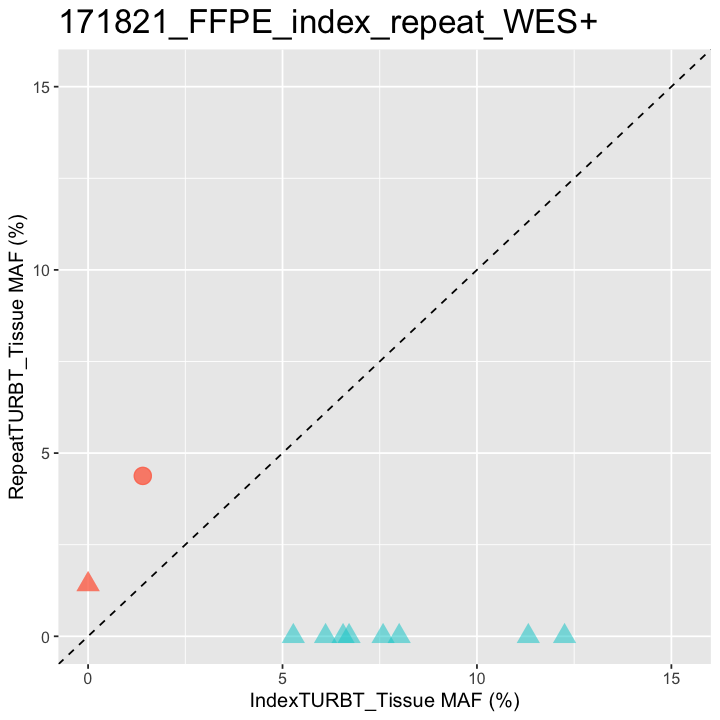

[1] "175672"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 90
[1] 86
[1] 97
[1] 79


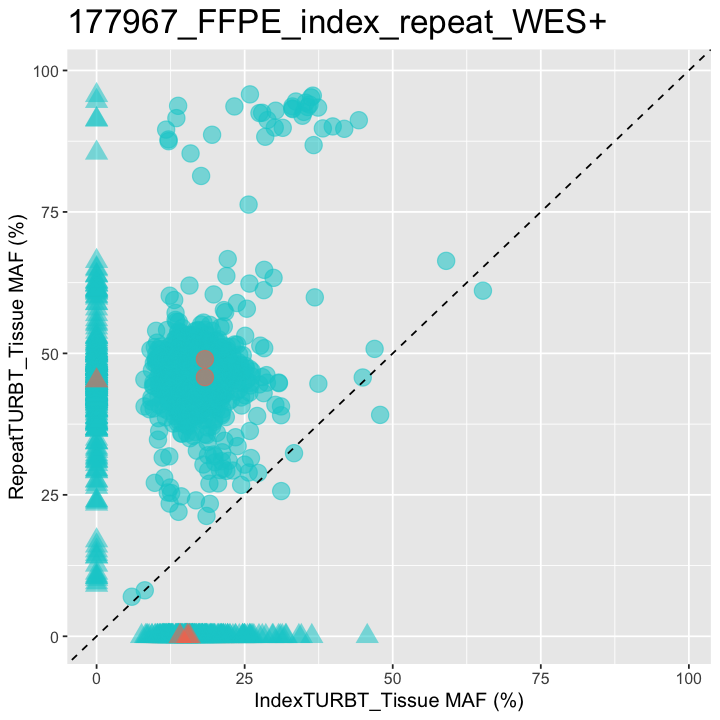

[1] "175425"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 169
[1] 13
[1] 171
[1] 11


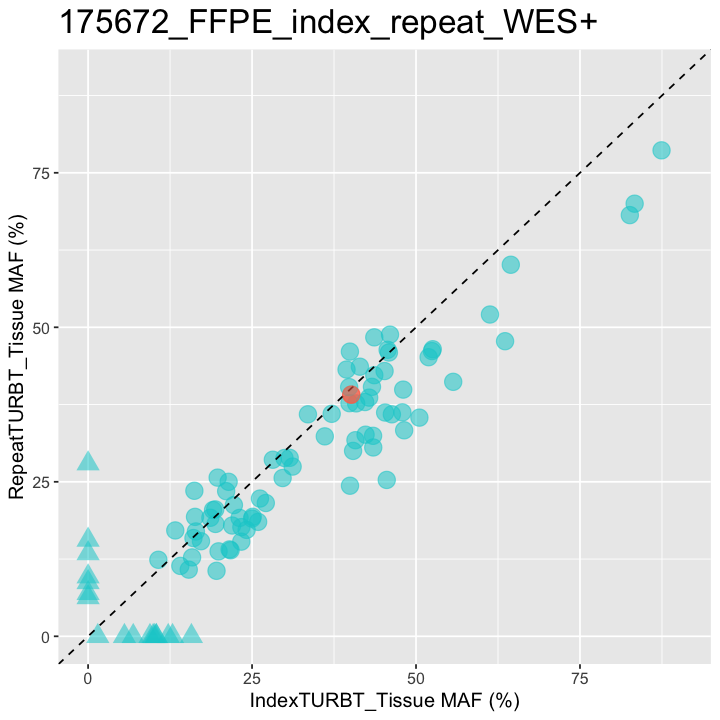

[1] "178886"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 513
[1] 90
[1] 516
[1] 87


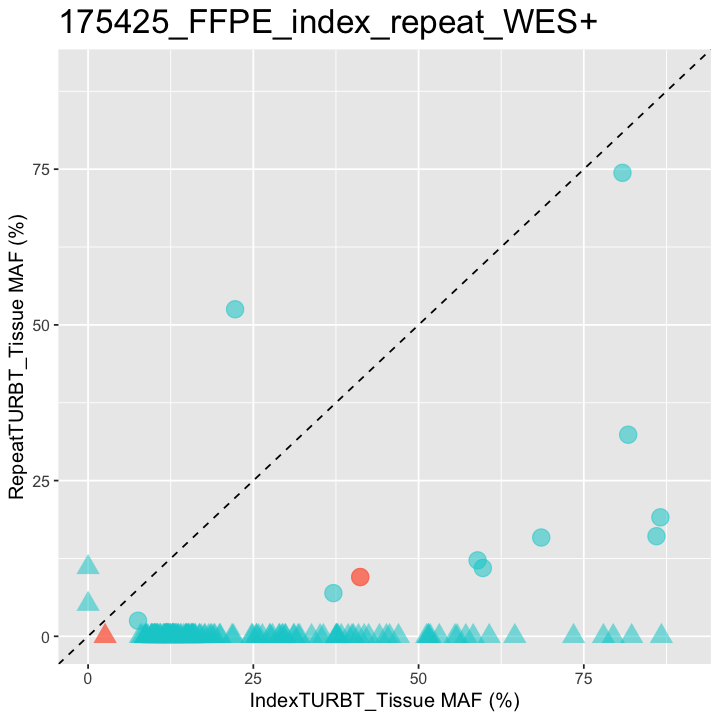

[1] "173350"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 341
[1] 7
[1] 342
[1] 6


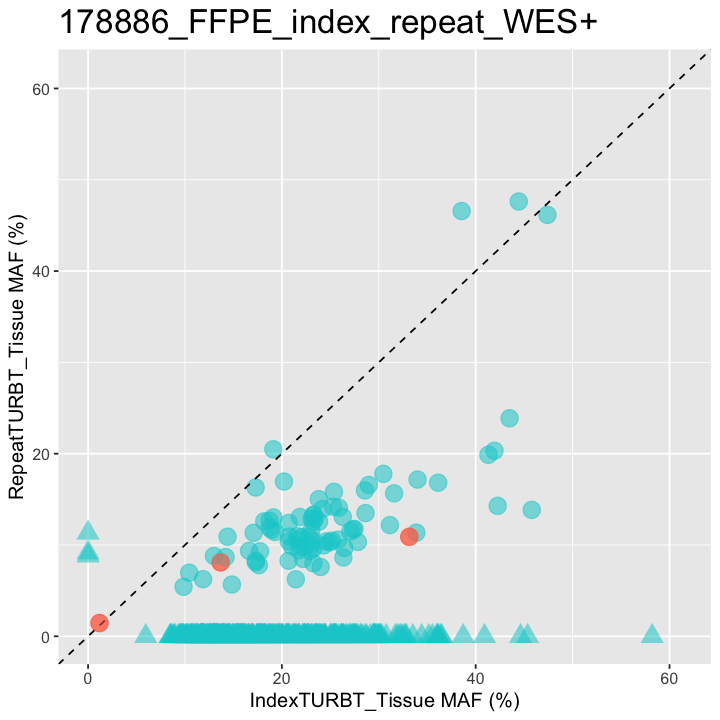

[1] "175387"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 38
[1] 43
[1] 81
[1] 0


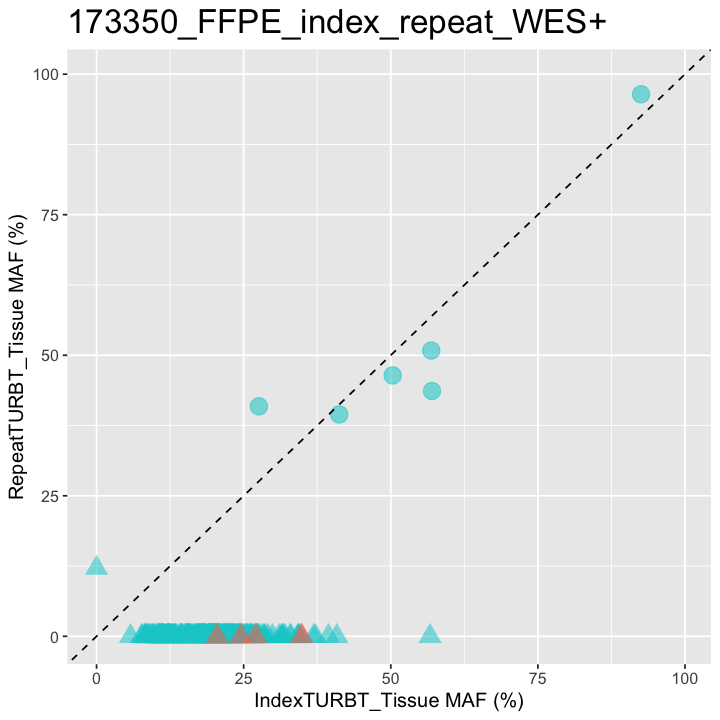

[1] "174083"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 6
[1] 9
[1] 13
[1] 2


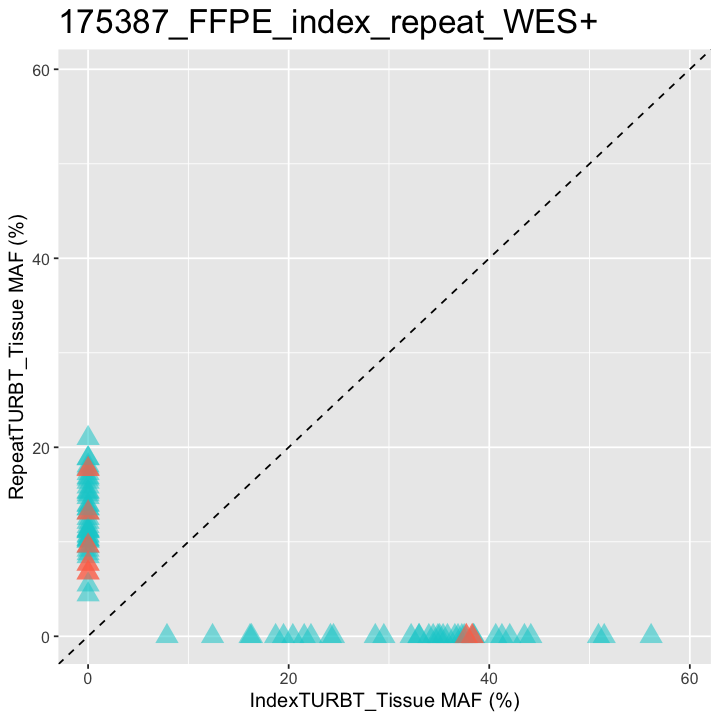

[1] "175854"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 182
[1] 172
[1] 188
[1] 166
[1] "175725"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 316
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
[1] 316
[1] 0


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


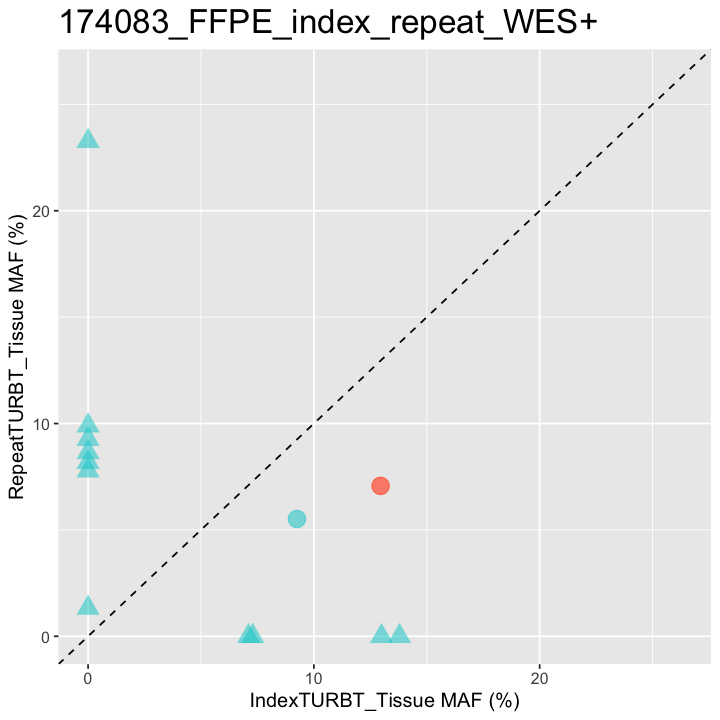

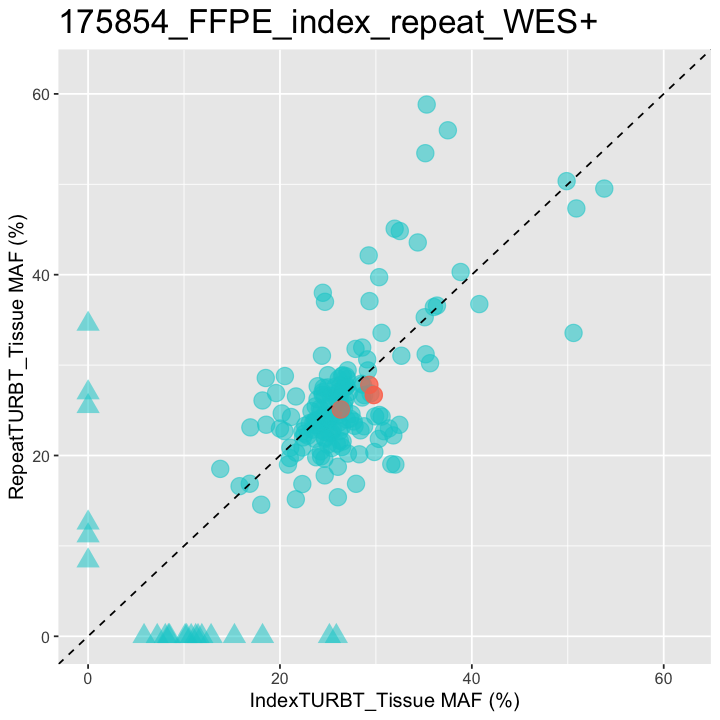

[1] "176992"
[1] "all.snvs"
[1] "samples"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 77
[1] 33
[1] 91
[1] 19


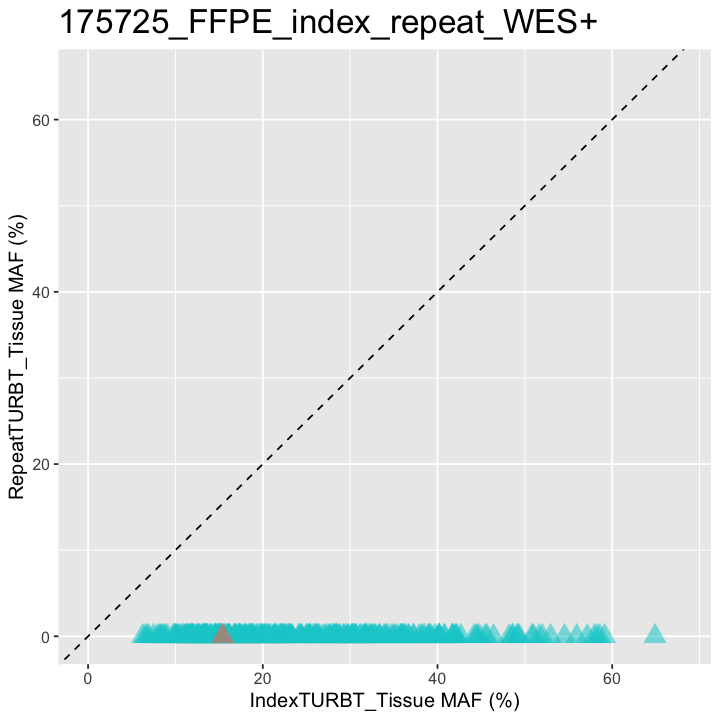

pdf 
  2

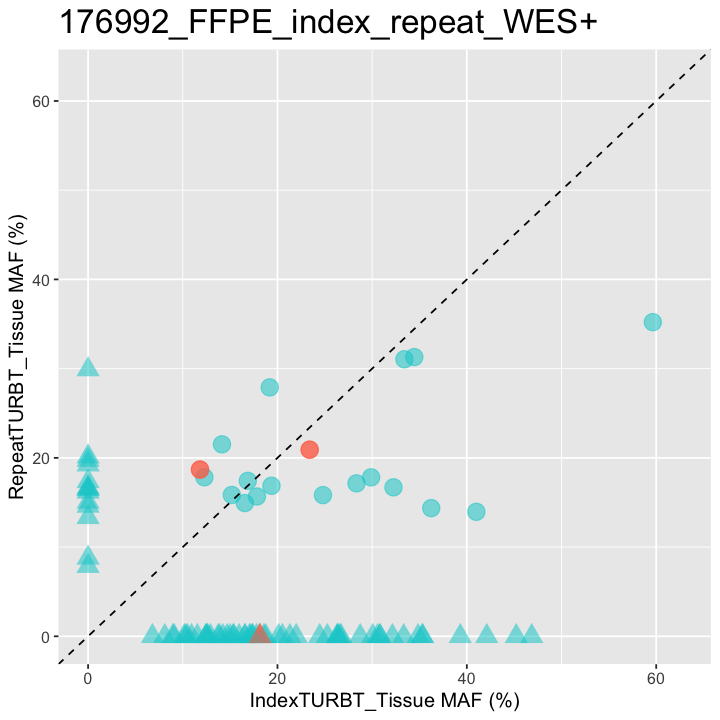

In [191]:
# rerun
## Concordance scatter plots
source("~/Desktop/puffin/R/compareMAFs.R")

#df_clin_sel = df_clin %>% filter(has.IndexTURBT==1, has.repeatTURBT==1) #006 and 001 have failed index samples

# patched
#all.snv_wes_p_sel = all.snv_wes_p %>% filter(PatientID %in% df_clin_sel$PatientID)
# WARN: patched variants are often info==NA here

plot.me = TRUE
patients = unique(df_ffpe_paired$PatientID)
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_FFPE_index_repeat_WES+")
    pid.snv_wes = all.ffpe_snv %>% filter(PatientID==pid)
    pid.out = compareMAFs(pid.snv_wes, selectors=c("IndexTURBT_Tissue","RepeatTURBT_Tissue"),samples = df_ffpe_paired, 
                            plot=plot.me, legend.position="none", plot.title=plot.title, 
                         color.by="white.list",color.by.foreground.value = "TRUE", colors=c("TRUE"="coral1","FALSE"="darkturquoise"))
    plots[[paste0(pid,".1")]] = pid.out$plot
}
#p <- do.call("grid.arrange", c(plots, ncol=ncol))
#options(repr.plot.width=15, repr.plot.height=5*length(patients))
#plot(p)
pdf("./data_batch3_02222023/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_05052023.pdf", onefile = TRUE)
for (p in names(plots)){
    show(plots[[p]])
}
dev.off()

# conclusions
# MAFs are generally lower at repeat across all somatic mutaitons. 
# Pathogenic/unknown whitelist mutations  - are any new at repeat? what percentage are these?
                                # only 6 variants are pathogenic/unk and whitelist # 16 are either or
                                # 14 total are whitelist
                                # 8 total are pathogenic/unk # outline the important ones
# which ones increase in frequency, which decerase? percentages?

In [69]:
# one big concordance plot: 
source("~/Desktop/puffin/R/compareMAFs.R")
unique(all.ffpe_snv$PatientID)
unique(all.ffpe_snv$StudyVisit)
unique(all.ffpe_snv$SampleType)
nrow(all.ffpe_snv)
pdf("./data_batch3_02222023/MAFs_index_vs_repeat_nonpatched_all_05092023.pdf", height=10, width=12)
options(repr.plot.width=10, repr.plot.height=10)
df_concord = compareMAFs(all.ffpe_snv, selectors=c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), 
                         samples=df_ffpe_paired_wgerm, plot=TRUE, fill.na=0)

# df_concord = df_concord %>% filter(grepl("somatic", VariantType.x, ignore.case=T), Concordant=="TRUE")
# length(unique(df_concord$PatientID)) # 5 patients with any concordant variants (out of 6)
# ## correlation
# library(stats)
# cor.test(df_concord$VariantFreq.x, df_concord$VariantFreq.y, method="spearman")
dev.off()

[1] "NMIBC006" "NMIBC010" "NMIBC005" "NMIBC035" "NMIBC009" "NMIBC019"
 [7] "NMIBC016" "NMIBC003" "NMIBC013" "NMIBC014" "NMIBC021" "NMIBC033"
[13] "175526"   "116381"   "174091"   "172749"   "167162"   "173975"  
[19] "174947"   "175610"   "175325"   "176349"   "172229"   "175492"  
[25] "175733"   "176828"   "176388"   "171821"   "177967"   "182022"  
[31] "173912"   "175672"   "175425"   "175648"   "178886"   "174872"  
[37] "173350"   "175387"   "152237"   "173281"   "174083"   "175854"  
[43] "175725"   "176992"   "173075"   "180264"

[1] "RepeatTURBT" "IndexTURBT"

[1] "Tissue"

[1] 14802

[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 6302
[1] 2731
 [1] "NMIBC010" "NMIBC005" "NMIBC035" "NMIBC016" "NMIBC013" "NMIBC014"
 [7] "NMIBC033" "175526"   "172749"   "167162"   "173975"   "175610"  
[13] "175325"   "175492"   "176828"   "171821"   "177967"   "175672"  
[19] "175425"   "178886"   "173350"   "175387"   "174083"   "175854"  
[25] "175725"   "176992"  


pdf 
  2

In [70]:
library(eulerr)
source("~/Desktop/puffin/R/get_concordance_stats.R")

# does not include CNVs
options(repr.plot.width=6, repr.plot.height=6)
pdf("./data_batch3_02222023/Venn_WES+_variants_unpatched_05092023.pdf", width=5, height=5)

concordance_venn(variants=all.ffpe_snv, samples = df_ffpe_paired_wgerm, 
                 selectors = c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), colors = c("IndexTURBT_Tissue"="cornflowerblue",
                                                                                 "RepeatTURBT_Tissue"="darkgreen"))
dev.off()


# Bi-directionally Patched
#pdf("./ASCO_GU/Venn_WES+_variants_patched_12072022.pdf", width=5, height=5)


        
         IndexTURBT RepeatTURBT
  Tissue       6302        2731

 IndexTURBT_Tissue RepeatTURBT_Tissue 
              6302               2731 


pdf 
  2

In [90]:
vars = rbind.common(all.ffpe_snv, all.ffpe_cnv)
names(vars)

df_out = get_concordance_stats(variant.data = vars, ref_sample_type = "IndexTURBT_Tissue", 
                            df_samples = df_ffpe_paired_wgerm)
df_out = df_out %>% filter(StudyVisit=="RepeatTURBT", PatientID != "NMIBC016")
df_out
summarize_vector(df_out$pct.concord)
sum(df_out$n_concord_vars)/sum(df_out$n_sample_vars) ## check 175387 . . . ???

[1] "seqnames"               "start"                  "end"                   
 [4] "CopyNumber"             "VariantID"              "sampleDir"             
 [7] "sampleFolder"           "externalSampleID"       "SpecimenType"          
[10] "trialVisitNum"          "ID"                     "highFrequent.inbatch"  
[13] "concordant"             "SampleID.short"         "Chromosome"            
[16] "Variant_Classification" "Hugo_Symbol"            "PatientID"             
[19] "StudyVisit"             "SampleType"

[1] "IndexTURBT"  "RepeatTURBT"
[1] "Tissue"
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 147.5"
[1] "min: 1"
[1] "max: 1392"
[1] "sd: 322.201188939219"
[1] "MRD sample: RepeatTURBT_Tissue"
[1] "median number MRD variants: 39.5"
[1] "min: 0"
[1] "max: 1116"
[1] "sd: 223.902822327352"


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NMIBC005,P220070,Tissue,RepeatTURBT,86,73,68,5,93.15068,RepeatTURBT_Tissue
NMIBC010,P220075,Tissue,RepeatTURBT,107,99,59,40,59.59596,RepeatTURBT_Tissue
NMIBC013,P228852,Tissue,RepeatTURBT,1392,7,1,6,14.28571,RepeatTURBT_Tissue
NMIBC014,P220078,Tissue,RepeatTURBT,417,309,301,8,97.41100,RepeatTURBT_Tissue
NMIBC033,P220084,Tissue,RepeatTURBT,30,2,1,1,50.00000,RepeatTURBT_Tissue
NMIBC035,P220086,Tissue,RepeatTURBT,169,118,94,24,79.66102,RepeatTURBT_Tissue
175526,P228873,Tissue,RepeatTURBT,439,50,46,4,92.00000,RepeatTURBT_Tissue
172749,P228847,Tissue,RepeatTURBT,1,8,0,8,0.00000,RepeatTURBT_Tissue
167162,P228842,Tissue,RepeatTURBT,12,48,9,39,18.75000,RepeatTURBT_Tissue


[1] "df_out$pct.concord"
[1] "n.obsv.: 25"
[1] "mean: 58.53182083393"
[1] "median: 64.4859813084112"
[1] "min: 0"
[1] "max: 100"
[1] "sd: 34.6761674690978"
58.53 (0-100)


[1] 0.7392241

In [61]:
### Bi Dir Patched data set summary table ## FILTERED 12/20
# all.snv_wes_p_f = all.snv_wes_p %>% filter(!grepl("synon", Consequence))

# cols = c("SampleID.short","Hugo_Symbol","VariantID","StudyVisit","SampleType","PatientID")
# all.var_wes_p_f = rbind(all.snv_wes_p_f[,cols], all.cnv_wes[,cols])

# df_concord_counts_p = get_max_concord_maf(all.var_wes_p_f, "FFPE", "IndexTURBT", df_samples)

# # format
# stopifnot(length(df_concord_counts_p $SampleID.short) == length(df_samples$SampleID.short)) #check dupes
# df_concord_counts_p  = df_concord_counts_p  %>%
#     mutate(n_concord_vars = as.numeric(n_concord_vars), n_sample_vars = as.numeric(n_sample_vars)) %>%
#     mutate(diff= n_sample_vars - n_concord_vars) 
# df_concord_counts_p  = df_concord_counts_p  %>% filter(StudyVisit=="RepeatTURBT") #select one sample per patient
# df_concord_counts_p 

# df_out = apply(df_concord_counts_p , 2, as.character)
#write.csv(df_out, file="./AUA/abstract1_table_reference.csv", row.names=FALSE) # output non-patched variant set
#write.csv(df_out, file="./ASCO_GU/abstract_table_reference_NS_patched.csv", row.names=FALSE) # output patched variant set


In [77]:
# set annotation colors

# sample_type_cols = RColorBrewer::brewer.pal(n=8, name="Set1")[c(7,6,3,1)]
# names(sample_type_cols) = c("ffpe", "urine", "ucp","plasma")

sex_cols = RColorBrewer::brewer.pal(n=8, name = "Set1")[c(2,8)]
names(sex_cols) = c("Male","Female")

smoking_cols = RColorBrewer::brewer.pal(n = 8,name = "Greys")[c(6,8)]
names(smoking_cols) = c("Never smoked","Former smoker")

stage_cols = RColorBrewer::brewer.pal(n=8, name="Greens")[c(1,2,3,5,6,8)]
names(stage_cols) = c("T0","Tis","TaLG","TaHG","T1",">=T2")

# i_grade_cols = RColorBrewer::brewer.pal(n=8, name="Oranges")[c(1,3,7)]
# names(grade_cols) = c("Undetermined","Low","High")

# r_stage_cols = RColorBrewer::brewer.pal(n=8, name="Blues")[c(1,2,3,4,6,8)]
# names(r_stage_cols) = c("T0","Tis only","TaLG","TaHG","T1",">=T2")

history_cols = RColorBrewer::brewer.pal(n=8, name="BuPu")[c(2,8)]
names(history_cols) = c("No","Yes")

IVT_cols = RColorBrewer::brewer.pal(n=8, name="Set3")[1:4]
names(IVT_cols)=c("None","BCG","Gemcitabine +/- Docetaxel)","Mitomycin.C")

CIS_cols = RColorBrewer::brewer.pal(n=8, name="Reds")[c(1,8)]
names(CIS_cols) = c("No","Yes")

#histol_cols = c("Urothelial"="lightblue", "Sqamous Cell Carcinoma"="lightgreen")

#cnb_cols = colorRamp2(c(7.5,11.5), c("white", "red4"))
# Generate Oncoprint



[1] "df_samples"
[1] "snv.data"
[1] "cnv.data"
[1] "Consequence reduced colors"
   Missense  Truncating    In_Frame      UTR_5p      UTR_3p    Promoter 
"darkgreen"      "blue"   "darkred"     "cyan3"    "maroon"      "pink" 
       Gain        Loss   Multi_hit 
    "black"    "grey52"     "black" 
[1] "variant.data"
[1] "df_samples"
[1] "WARN: some variants finalKeep term unrecognized. Keeping these"
[1] TRUE   NA
[1] "WARN: some varaints is.na(Variant_Type). Treating as somatic."
[1] "Variant types present (selecting somatic):"
[1] "Somatic"        "Likely somatic"


WARN: NA or missing values in Tumor_Seq_Allele2: 1

WARN: NA or missing values in Chromosome: 1

WARN: NA or missing values in Start_Position: 1

WARN: NA or missing values in End_Position: 1

WARN: NA or missing values in Reference_Allele: 1

WARN: NA or missing values in Variant_Type: 1

WARN: NA or missing values in Hugo_Symbol: 1



[1] "Selected snvs: 1540"
[1] "variant.data"
[1] "df_samples"
[1] "Selected CNVs: 81"
-Validating
--Found  1  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  In_Frame
  Promoter
  N.A.
  NULL
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  NA
-Processing copy number data
-Summarizing
--Possible FLAGS among top ten genes:
  NEB
  DNAH11
-Processing clinical data
-Finished in 0.080s elapsed (0.079s cpu) 
                 Tumor_Sample_Barcode Tumor_Seq_Allele2 Chromosome
1: P220074_NMIBC010_indexturbt_tissue                 A       chr1
2: P220074_NMIBC010_indexturbt_tissue                 G       chr1
3: P220074_NMIBC010_indexturbt_tissue                 T       chr1
4: P220074_NMIBC010_indexturbt_tissue                 G       chr1
5: P220074_NMIBC010_indexturbt_tissue                 C       chr1
6: P220074_NMIBC010_indexturbt_tissue   

All mutation types: indexturbt_tissue.Loss, indexturbt_tissue.Missense,
repeatturbt_tissue.Missense, indexturbt_tissue.Truncating,
repeatturbt_tissue.Truncating, indexturbt_tissue.Gain,
repeatturbt_tissue.Gain, repeatturbt_tissue.Multi_hit,
indexturbt_tissue.Promoter, repeatturbt_tissue.Promoter,
indexturbt_tissue.Multi_hit.

Colors are not defined for: repeatturbt_tissue.Missense,
repeatturbt_tissue.Truncating, repeatturbt_tissue.Promoter,
repeatturbt_tissue.Gain, repeatturbt_tissue.Multi_hit,
indexturbt_tissue.Missense, indexturbt_tissue.Truncating,
indexturbt_tissue.Promoter, indexturbt_tissue.Gain,
indexturbt_tissue.Loss, indexturbt_tissue.Multi_hit. They won't be
shown in the barplots.



$oncoprint

$legend
A pack of 2 legends


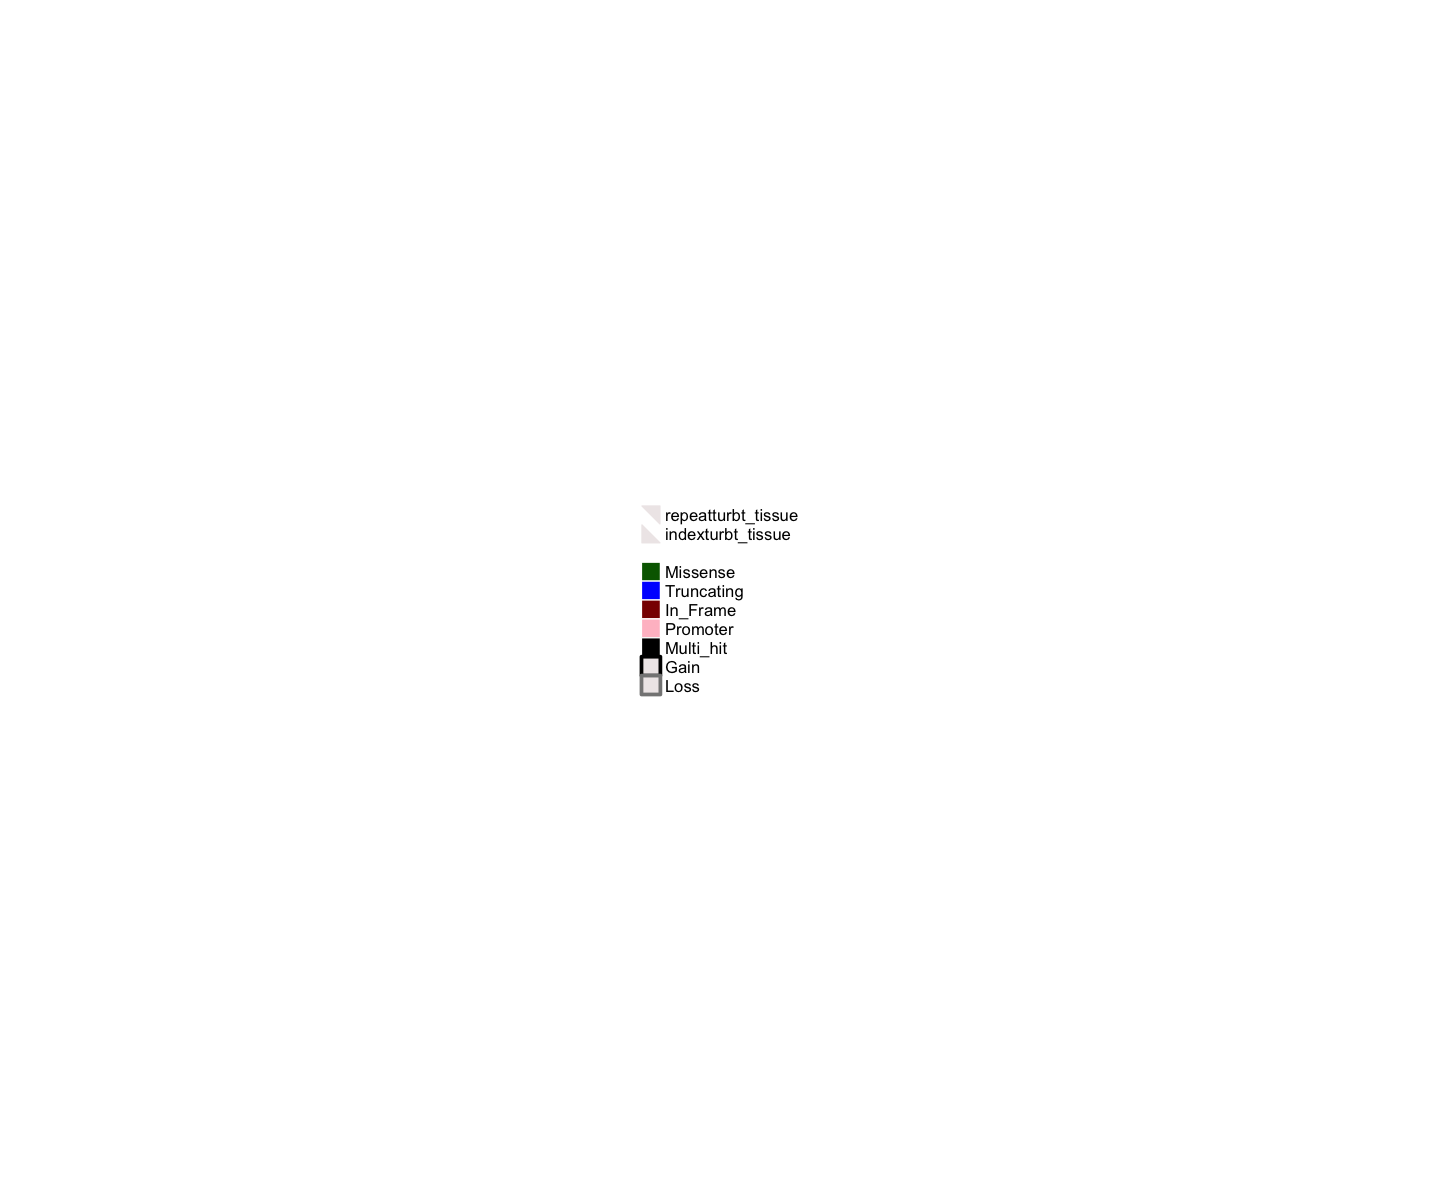

In [89]:
source("~/Desktop/puffin/R/concordance_oncoprint.R") # rerun

df_annot = df_clin %>%
    mutate(Index.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Index.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2")),
           Repeat.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Repeat.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    select("Smoking.Status", "Sex",
           "Previous history of NMIBC", "Prev.IV.Therapy",
           "Index.Stage", 'Index.CIS', "Repeat.Stage","Repeat.CIS", 
           "PatientID") 
df_samples = df_ffpe_index_repeat_paired %>%
               left_join(df_annot %>% select(Index.Stage, Repeat.Stage, PatientID), by="PatientID") %>%
               arrange(Index.Stage, Repeat.Stage)  # set the order
           
df_annot = df_annot %>% 
    rename("Index Stage"="Index.Stage","Repeat Stage"= "Repeat.Stage",
           "CIS at Index"="Index.CIS","CIS at Repeat"="Repeat.CIS",
                               "Smoking Status"= "Smoking.Status",
                               "Prev. IV Therapy"="Prev.IV.Therapy", 
                               "Previous History of NMIBC"="Previous history of NMIBC") # format the names

annot.colors = list("Index Stage" = stage_cols, 
                     "Repeat Stage"= stage_cols,
                     "CIS at Index" = CIS_cols,
                     "CIS at Repeat"= CIS_cols,
                     "Prev. IV Therapy"= IVT_cols,
                     "Previous History of NMIBC" = history_cols,
                     "Smoking Status" = smoking_cols,
                     "Sex" = sex_cols)

out.file = "./AUA/OncoPrint_Index_vs_Repeat_FFPE_unpatched_04042023"
concordance_oncoprint(snv.data = all.snv_wes,
                      cnv.data = all.cnv_wes,
                      df_samples = df_samples,
                      ref_sample_type="IndexTURBT_Tissue",
                      mrd_sample_type="RepeatTURBT_Tissue",
                      clin.data = df_annot,
                      show.clin.data = T,
                      clin.data.cols = names(annot.colors),
                      clin.annotation.colors = annot.colors,
                      show.patient.id=F,
                      make.legend=T,
                      concord.barplot=F,
                      show.top.n=25,
                      var.reduc.set="consequence_reduced",
                      var.colors="consequence_reduced",
                      out.file=out.file)

## some variants still == NULL annotation . . . look into this

In [333]:
source("~/Desktop/puffin/R/concordance_oncoprint.R") # rerun
#all.cnv_ = format_as_MAF(all.ffpe_cnv, df_samples = df_ffpe_qc, variant.type = "cnv", maf.output = F)  # update later

out.file = "./data_batch3_02222023/OncoPrint_Index_vs_Repeat_FFPE_unpatched_05082023"
concordance_oncoprint(snv.data = all.ffpe_snv,
                      cnv.data = all.ffpe_cnv, # already is maf
                      df_samples = df_ffpe_paired_wgerm,
                      ref_sample_type="IndexTURBT_Tissue",
                      mrd_sample_type="RepeatTURBT_Tissue",
                      clin.data = df_ffpe_paired_wgerm %>% filter(StudyVisit=="IndexTURBT") %>% select(PatientID, SampleType, StudyVisit),
                      show.clin.data = T,
                      #clin.data.cols = names(annot.colors),
                      #clin.annotation.colors = annot.colors,
                      show.patient.id=T,
                      make.legend=F,
                      concord.barplot=T,
                      show.top.n=25,
                      var.reduc.set="consequence_reduced",
                      var.colors="consequence_reduced",
                      out.file=out.file)

[1] "WARN: these variant classes missing from var.colors."
       class present
1       Gain   FALSE
2       Loss   FALSE
3   Missense   FALSE
4 Truncating   FALSE
5   In_Frame   FALSE
6   Promoter   FALSE
7     UTR_5p   FALSE
[1] "TRUE" NA    
[1] "WARN: some variants finalKeep term unrecognized. Keeping these"
[1] "WARN: some varaints is.na(Variant_Type). Treating as somatic."
[1] "SNV types present (selecting somatic):"
[1] "Somatic"        "Likely somatic"


Adding missing grouping variables: `PatientID`
warn_na: WARN: NA or missing values in Tumor_Seq_Allele2: 39

warn_na: WARN: NA or missing values in Chromosome: 39

warn_na: WARN: NA or missing values in Start_Position: 39

warn_na: WARN: NA or missing values in End_Position: 39

warn_na: WARN: NA or missing values in Reference_Allele: 39

warn_na: WARN: NA or missing values in Variant_Type: 39

warn_na: WARN: NA or missing values in Hugo_Symbol: 39

warn_na: WARN: NA or missing values in Tumor_Sample_UUID: 38



[1] "Selected snvs: 6121"
[1] "Selected CNVs: 148"
-Validating
--Found  39  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  In_Frame
  N.A.
  Promoter
  UTR_5p
  NULL
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  indel
  NA
-Silent variants: 15 
-Processing copy number data
-Summarizing
--Possible FLAGS among top ten genes:
  DNAH11
-Processing clinical data
--Annotation missing for below samples in MAF:
  P228841_167162_NA_NA
  P228842_167162_NA_NA
  P228843_171821_NA_NA
  P228844_171821_NA_NA
  P228846_172749_NA_NA
  P228847_172749_NA_NA
  P228853_173350_NA_NA
  P228854_173350_NA_NA
  P228856_173975_NA_NA
  P228857_173975_NA_NA
  P228858_174083_NA_NA
  P228859_174083_NA_NA
  P228864_175325_NA_NA
  P228865_175325_NA_NA
  P228866_175387_NA_NA
  P228867_175387_NA_NA
  P228868_175425_NA_NA
  P228869_175425_NA_NA
  P228870_175492_NA_NA
 

Found NA values in the matrix and treat as no alteration. If `NA` means
no alteration, you can explicitly set it to empty strings like ''. If
`NA` is an alteration type, you should format it to a string like
`'NA'` and define graphics for it.

All mutation types: .



ERROR: Error in mat_list[[1]]: subscript out of bounds


In [ ]:
## old 3-way concordance barplot # move to puffin
### select concordant mutation count (see if filtered above)
# concord_counts = df_concord_counts[match(df_annot$PatientID, df_concord_counts$PatientID.x),]
# concord_counts$index_only = as.numeric(concord_counts$n_ref_vars) - concord_counts$n_concord_vars
# concord_counts = concord_counts %>% select(n_concord_vars, diff, index_only) %>%
#         rename("Concordant"= n_concord_vars, "Repeat only"=diff, "Index only"=index_only)

# ## barplot axis label
# concord_muts_annot = HeatmapAnnotation(N.Variants = anno_barplot(as.matrix(concord_counts),
#                                                                             axis = TRUE, 
#                                                                             axis_param = list(gp=gpar(fontsize=10),
#                                                                                               at = c(50,100,150,200,250,300,400), 
#                                                                                               labels = c(50,100,150,200,250,300,400)), 
#                                                                                               height = unit(7, "cm")))

In [ ]:
# all.snv_wes %>% filter(SampleID.short=="P220080") # all variants for the repeat turbt were called as germline

## oncoplot of concordant urine/index mutations (only BEACON MRD markers and pathogenic hotspot panel variants, for AUA)

In [181]:
df_snv1 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00252_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv2 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00253_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv3 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00254_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")

df_snv = standardize_names(rbind(df_snv1,df_snv2,df_snv3)) %>% mutate(SampleID.short = make_SIDshort(sampleNames))
write.csv(df_snv, "./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short_urine.csv", row.names=F)

print("summary")

df_all_vars = df_snv %>%  
    group_by(SampleID.short) %>% summarize(all.mutations.clinicOnly=n())

df_good_vars = df_snv %>% 
    filter(finalKeep %!in% c("FALSE","lowConfidence"),
                             grepl("somatic", VariantType, ignore.case=T)) %>%
    group_by(SampleID.short) %>% summarize(good.mutations.clinicOnly=n())

df_all_probes = df_snv %>% filter(wl.tier=="T00") %>%
    group_by(SampleID.short) %>% summarize(detected.probes.clinicOnly=n())

df_good_probes = df_snv %>% 
                            filter(finalKeep %!in% c("FALSE","lowConfidence"),
                                   grepl("somatic", VariantType, ignore.case=T)) %>%
                            filter(wl.tier=="T00") %>%
   group_by(SampleID.short) %>% summarize(good.detected.probes.clinicOnly=n())

df_summary = df_all_vars %>% full_join(df_good_vars, by="SampleID.short") %>% 
                             full_join(df_all_probes, by="SampleID.short") %>% 
                             full_join(df_good_probes, by="SampleID.short") %>% 
                             left_join(mrd.table, by="SampleID.short") %>%
                             left_join(df_clin %>% select(PatientID, is.repeat.pos), by="PatientID") %>% 
                             filter(StudyVisit %!in% c("Post TURBT","Surveillance 1"),
                                    SampleType %in% c("Urine","UCP")) %>%
                             relocate(PatientID, SampleID.short, SampleType, StudyVisit, is.repeat.pos, MRD.call)
df_summary ## MRD negative calls : 016 (true negative) and 021 (false negative, TF=0.00)

write.csv(df_summary, "./data/Urine-UCP/BEACON_pre_repeat_urine_mutaiton_counts_02172023.csv", row.names=F)

[1] "WARN: Missing: PatientID or SubjectID"
[1] "WARN: Missing: trialVisitNum or StudyVisit"
[1] "WARN: Missing: SampleType or SpecimenType"
[1] "summary"


PatientID,SampleID.short,SampleType,StudyVisit,is.repeat.pos,MRD.call,all.mutations.clinicOnly,good.mutations.clinicOnly,detected.probes.clinicOnly,good.detected.probes.clinicOnly,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NMIBC010,P217590,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,38,40,38,39,36,9.25,0.677,0.1625357483
NMIBC005,P217591,Urine,Pre-Repeat TURBT,TRUE,TRUE,41,40,34,34,27,29,2.50,0.705,0.3306003890
NMIBC035,P217592,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,40,36,36,40,36,36.00,0.683,0.0579642593
NMIBC009,P217594,Urine,Pre-Repeat TURBT,FALSE,TRUE,38,32,34,31,33,30,31.50,0.380,0.0072417228
NMIBC019,P217595,Urine,Pre-Repeat TURBT,FALSE,TRUE,54,29,53,28,38,36,29.00,0.702,0.0005027954
NMIBC016,P217596,Urine,Pre-Repeat TURBT,FALSE,FALSE,26,NA,26,NA,6,6,1.50,0.589,0.0000000000
NMIBC021,P219768,Urine,Pre-Repeat TURBT,TRUE,FALSE,32,22,32,22,2,2,1.00,0.281,0.0000000000
NMIBC003,P219770,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,77,69,69,72,64,8.75,0.643,0.6641799480
NMIBC013,P219771,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,67,75,65,72,70,68.50,0.676,0.0039131614


In [78]:
unique(df_qc$StudyVisit)
unique(df_qc$SampleType)

df_clin_annot = df_clin %>% mutate(#SampleType2 = "Tissue",
           Index.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Index.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2")),
           Repeat.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Repeat.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Index.Stage) %>% 
    select(#"Tumor_Sample_Barcode", 
           "Smoking.Status", "Sex",
           "Previous history of NMIBC", "Prev.IV.Therapy",
           "Index.Stage", 'Index.CIS', "Repeat.Stage","Repeat.CIS","PatientID", "is.repeat.pos")


[1] "IndexTURBT"       "RepeatTURBT"      "Pre-Repeat TURBT" "Post TURBT"      
[5] "Surveillance 1"

[1] "FFPE"   "PBMC"   "Urine"  "Plasma" "UCP"

In [131]:
# select samples with qc!="Fail", has.Index, has MRD results even if no variants, 
source("~/Desktop/puffin/R/format_as_MAF.R")

df_ffpe_index = df_qc %>% filter(SampleType=="FFPE", StudyVisit=="IndexTURBT")
nrow(df_ffpe_index)
df_pre_urine_ucp = df_qc %>% filter(SampleType %in% c("Urine","UCP"), 
                                    StudyVisit=="Pre-Repeat TURBT",
                                    SampleID.short %in% df_mrd$SampleID.short,
                                    PatientID %in% df_ffpe_index$PatientID) %>%
                         left_join(df_clin_annot, by="PatientID") %>% 
                         rename("Smoking.Status"="Smoking.Status",
                                "Prev.History.NMIBC"="Previous history of NMIBC") %>%
                         mutate(across(everything(), as.character))
                         
# select variants
df_snv_sel = df_snv %>% filter(SampleID.short %in% df_pre_urine_ucp$SampleID.short, 
                               wl.tier=="T00") %>%
                        left_join(df_pre_urine_ucp, by="SampleID.short")

# must be a line in the maf snv data for all samples to include zero variant samples in plot
df_snv_selected_maf = format_as_MAF(df_snv_sel, df_pre_urine_ucp, # with df_samples input, includes 0 var samples
                                    variant.type="snv")
unique(df_snv_selected_maf$Tumor_Sample_Barcode)


[1] 11

Warning message in if (is.na(df_samples)) {:
“the condition has length > 1 and only the first element will be used”


[1] "Selected snvs: 399"


[1] "NMIBC033_Pre-Repeat TURBT_UCP"   "NMIBC021_Pre-Repeat TURBT_Urine"
 [3] "NMIBC003_Pre-Repeat TURBT_Urine" "NMIBC013_Pre-Repeat TURBT_Urine"
 [5] "NMIBC014_Pre-Repeat TURBT_Urine" "NMIBC010_Pre-Repeat TURBT_Urine"
 [7] "NMIBC005_Pre-Repeat TURBT_Urine" "NMIBC035_Pre-Repeat TURBT_Urine"
 [9] "NMIBC009_Pre-Repeat TURBT_Urine" "NMIBC019_Pre-Repeat TURBT_Urine"
[11] "NMIBC016_Pre-Repeat TURBT_Urine"

In [ ]:
## it seems that all urine variants were filtered out for patient NMIBC016
names(df_snv_sel)
df_snv_sel %>% filter(grepl('NMIBC016', PatientID)) %>% relocate(PatientID, SampleType, VariantType, finalKeep)

## NMIBC-021 had 2 variants detected, but had MRD.score=1.0

In [132]:
# there must be a color for Variant_Classification that is N.A. for placeholder mutations
# filter out of plot using var_type_incl below

var_reduc_dict = list(Missense = c("missense_variant","missense_variant&splice_region_variant"),
                   Synonymous = c("synonymous_variant","stop_retained_variant"),
                   N.A. = c('downstream_gene_variant',"intergenic_variant", "N.A."),
                   Promoter = c("upstream_gene_variant"),
                   Truncating = c('frameshift_variant',
                                   'stop_gained',
                                   'start_lost',
                                   'splice_donor_variant',
                                   'stop_gained&splice_region_variant',
                                   'stop_retained_variant',
                                   'splice_acceptor_variant',
                                  "splice_region_variant&synonymous_variant",
                                  "splice_donor_variant",
                                   'stop_gained&frameshift_variant'),
                    Intronic = c("intron_variant","intron_variant&non_coding_transcript_variant"),
                    In_Frame = c('inframe_deletion','inframe_insertion'),
                    UTR_3p =c('3_prime_UTR_variant'),
                    UTR_5p =c('5_prime_UTR_variant'))

bgCol = "#CCCCCC" #default oncoplot bgdcol
var_color_vec = c(
    "Missense" = "darkgreen", 
    "Truncating" = "blue",
    "In_Frame" = "darkred",
    "UTR_5p" = "cyan3",
    "UTR_3p" = "pink",
    "Gain" = "black",
    "Loss" = "grey52",
    "Multi_Hit" = "grey39",
    "Intronic"="springgreen3",
    "Synonymous"="slateblue1",
    "Promoter"="indianred3",
    "N.A."= bgCol
)

df_snv_selected_maf$Variant_Classification = factor(df_snv_selected_maf$Variant_Classification)
levels(df_snv_selected_maf$Variant_Classification) <- var_reduc_dict

In [133]:
df_pre_urine_ucp = df_pre_urine_ucp %>% unite(Tumor_Sample_Barcode, c(PatientID,StudyVisit,SampleType), remove=FALSE)

var_type_include = unique(df_snv_selected_maf$Variant_Classification[df_snv_selected_maf$Variant_Classification!="N.A."])

dat <- read.maf(df_snv_selected_maf, 
                cnTable = NULL, 
                vc_nonSyn = var_type_include, 
                clinicalData = df_pre_urine_ucp)

-Validating
--Found  5  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  Synonymous
  Intronic
  N.A.
  UTR_3p
  In_Frame
  Promoter
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  substitution
  NA
-Silent variants: 6 
-Summarizing
-Processing clinical data
-Finished in 0.093s elapsed (0.049s cpu) 


In [145]:
# reference oncoplot (squares only) with all samples

#pdf('./AUA/Oncoplot_abstract2_MRD_11012022.pdf', width=15, height = 20)
pdf('./ASCO_GU/Beacon_Oncoplot_02152023.pdf', width=15, height = 25)

options(repr.plot.width=13, repr.plot.height=20)

#sample_type_cols = c("Urine"="darkgoldenrod1", "UCP"="darkgoldenrod3")

# for sample ordering
df_pre_urine_ucp = df_pre_urine_ucp %>% mutate(Repeat.Stage = factor(Repeat.Stage, levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Repeat.Stage, Index.Stage)
# PID_cols = colorRamps::primary.colors(n=length(df_pre_urine_ucp$PatientID))
# names(PID_cols) = df_pre_urine_ucp$PatientID

clin_cols = list(#SampleType=sample_type_cols, 
                 Sex=sex_cols, 
                 Smoking.Status=smoking_cols, 
                 Index.Stage=stage_cols,
                 Repeat.Stage=stage_cols,
                 Index.CIS=CIS_cols,
                 Repeat.CIS=CIS_cols,
                 Prev.History.NMIBC=history_cols,
                Prev.IV.Therapy=IVT_cols#,
                #PatientID=PID_cols
)

# must be a line in the maf snv data for all samples to include zero variant samples here
# all variant_classifications have to be in the var_color_vec for ANY colors to show up
oncoplot(dat, top=40, sortByMutation=F, showTitle = F, colors = var_color_vec, removeNonMutated = F, fill=T, barcode_mar = 8,
         showTumorSampleBarcodes=F, fontSize = 1.5, SampleNamefontSize = 1, sampleOrder = df_pre_urine_ucp$Tumor_Sample_Barcode,
          clinicalFeatures = c(#"SampleType"),
               "Repeat.Stage",
              "Index.Stage",
              "Repeat.CIS",
             "Index.CIS", 
             "Prev.History.NMIBC",
             "Prev.IV.Therapy",
             "Smoking.Status",
             "Sex"#,
#             "PatientID",
            #"is.repeat.pos"
         ),
        anno_height=3, gene_mar=12,
        drawRowBar=F, drawColBar=F, annotationColor=clin_cols,legendFontSize=3, annotationFontSize=1.5)


dev.off()

pdf 
  2

## compare concordance between BEACON urine and WES ffpes

In [103]:
# high conf variants

df_all_qc = read.csv(file = "./data/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-09-23_urine_ucp_pbmc_ffpe.csv",as.is=T) %>% filter(QC_Status!="Fail", Specimen_type!="Buffy Coat") %>%
                rename("StudyVisit"=trialVisitNum, "SampleType"=Specimen_type) %>%
                mutate("SampleID.short"=make_SIDshort(SampleID), "PatientID"=fix_PIDs(PatientID))

# Variant Short Marked inputs
# all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_supernatant_marked.csv") 
all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_supernatant_marked.csv",
                        as.is=T)
#all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_urine cell pellet_marked.csv")
all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_urine cell pellet_marked.csv",
                      as.is=T)
## FFPE variants, unpatched  ## use filtered?, or use Patched file here instead?
#all.ffpe.snv = read.csv("./data/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-06_tissue_marked.csv")
#all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_FFPE_filtered_double_patched.csv"
all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_filtered.csv",
                        as.is=T)

# beacon.markers = all.ffpe.snv %>% filter(Selected %in% c("Yes","Core"))
# You need to run the postAnalysis R script I provided for MRD panel design. 
# (/home/pdu/Projects/TechEval/Rscript_templates/MRD_analysis_template_V2.R)
# need also the hotspot panel regions
# can run on existing _filtered.csv file or find peters copy here:
# /home/pdu/Projects/OtherAnalysis/MOFFITT/PRDC-MOFFITT-NMIBC-MIBC-22001

# cols <- intersect(names(all.urine.snv), names(all.ffpe.snv))
# all.snv_unfilt = rbind(beacon.markers[,cols], all.ucp.snv[,cols], all.ffpe.snv[,cols]) %>%
#             distinct()

# all.snv = all.snv_unfilt %>% filter(grepl("somatic", VariantType, ignore.case=T), !(finalKeep %in% c("Low Confidence", "FALSE"))) %>%
#             mutate("SampleID.short"=make_SIDshort(sampleNames)) %>%
#             distinct() %>%
#             group_by(PatientID, VariantID) %>% mutate(CONCORDANT=(n()>1)) %>% ungroup()
# head(all.snv)
# # write.table(all.snv, "./data/Urine-UCP/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.txt", sep="\t",
# #             row.names=F, col.names=T, quote=F)

# nrow(all.snv)
# table(df_all_qc$SampleType)


In [46]:
out_bed = all.snv %>% mutate(zero = 0, dot = ".") %>% select(seqnames, start, end, VariantID, VariantFreq, PatientID, SpecimenType, trialVisitNum, SampleID.short)
write.table(out_bed, "./data/all_snv_ffpe_urine_ucp_short_somatic_12212022.bed", sep="\t", row.names=F, col.names=F, quote=F)

In [45]:
# run on server  ## change this to the hotspot panel PREDICINE_MRD_V1
# library(rtracklayer)
# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEATLAS_V2")
# export(tmp, 'ATLAS_V2_target_regions_12012022.bed')

# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEWES_V1") # couldnt transform this one to bed
# export(tmp, 'PREDICINEWES_V1_target_regions_12022022.bed')

# maybe overlap VRanges objects on server before export??
atlas.bed = read.csv("../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed", sep="\t",
                     stringsAsFactors=F, header=F)
names(atlas.bed) <- c("chr","start","stop","name","zero","dot")
tail(atlas.bed)

# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

,chr,start,stop,name,zero,dot
,<chr>,<int>,<int>,<chr>,<int>,<chr>
23280,chrY,2655606,2655727,chrY:2655607:2655727,0,.
23281,chrY,2847966,2848086,chrY:2847967:2848086,0,.
23282,chrY,6738492,6738612,chrY:6738493:6738612,0,.
23283,chrY,19490154,19490274,chrY:19490155:19490274,0,.
23284,chrY,26764543,26764664,chrY:26764544:26764664,0,.
23285,chrY,26764603,26764724,chrY:26764604:26764724,0,.


In [ ]:
# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

In [17]:
all.snv_atlas = read.csv("./data/NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed", sep="\t", header=F) 
names(all.snv_atlas) <- c("chr","start","end","VariantID","VariantFreq","PatientID","SampleType","StudyVisit", "SampleID.short")
all.snv_atlas = all.snv_atlas %>% distinct(SampleID.short, VariantID, .keep_all=T) # 655 variants
nrow(all.snv_atlas)
head(all.snv_atlas)

[1] 655

,chr,start,end,VariantID,VariantFreq,PatientID,SampleType,StudyVisit,SampleID.short
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,chr1,155874285,155874285,chr1:155874285:A:C,1.12274980,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
2,chr1,9781506,9781506,chr1:9781506:G:A,0.52239031,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
3,chr12,25398285,25398285,chr12:25398285:C:T,0.01697361,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
4,chr12,49426213,49426224,chr12:49426213:TGCAGCTGCAGA:T,1.73946203,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
5,chr13,103524589,103524589,chr13:103524589:C:T,1.10524994,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
6,chr16,2094797,2094797,chr16:2094797:C:T,0.40810100,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592


In [182]:
df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(intersect(df_pre_urine$PatientID, df_repeatT$PatientID), df_indexT$PatientID)

df_samples = rbind(df_pre_urine, df_repeatT, df_indexT) %>% filter(PatientID %in% patients)
table(df_samples$SampleType)


      Supernatant            Tissue Urine Cell Pellet 
                5                12                 1 

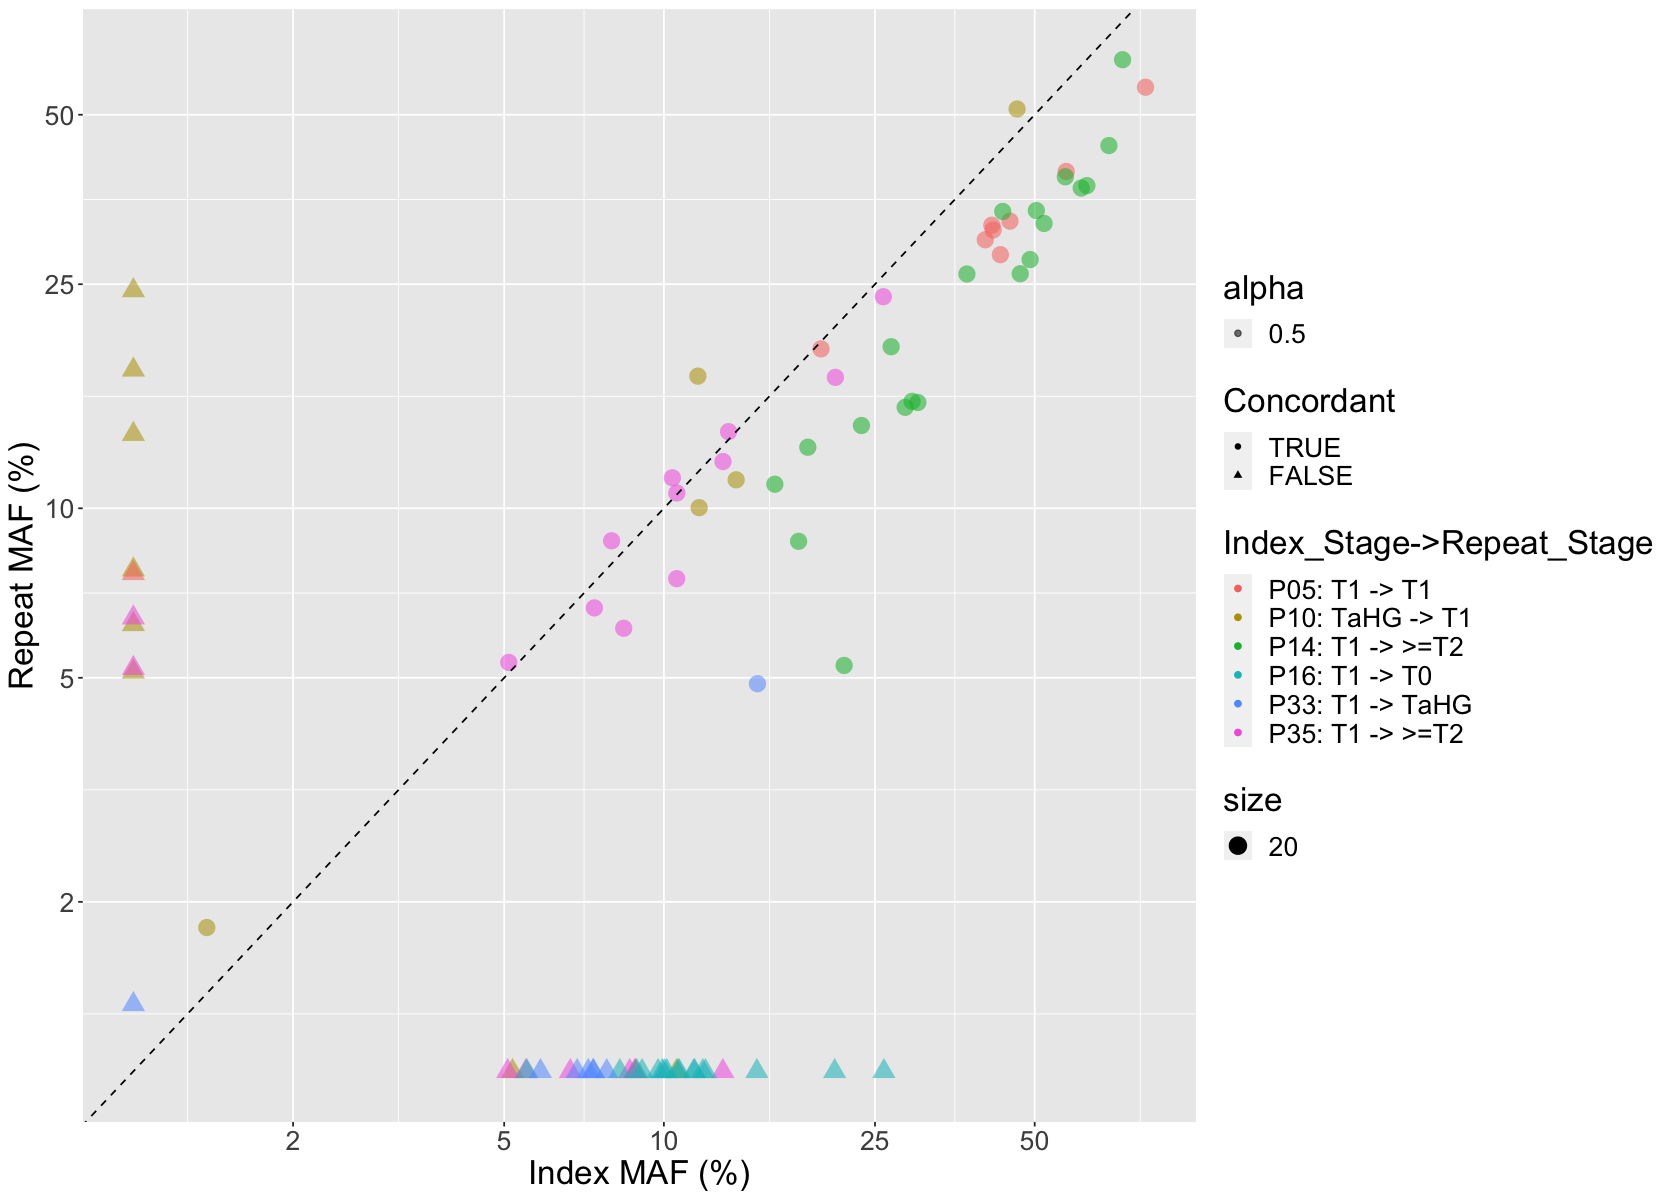

In [149]:
# index vs repeat frequency plot for ATLAS variants only, UNPATCHED, variant_short_all

# Unpatched
df_indexT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="IndexTURBT")
df_repeatT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="RepeatTURBT")
df_urineT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, SampleType %in% c("Supernatant", "Urine Cell Pellet"))

LOD = 1.0

df_compare_freq = df_indexT %>% full_join(df_repeatT, by=c("PatientID","VariantID"), suffix=c(".index",".repeat")) %>% 
    mutate(VariantFreq.index=ifelse(is.na(VariantFreq.index), LOD, VariantFreq.index),
           VariantFreq.repeat=ifelse(is.na(VariantFreq.repeat), LOD, VariantFreq.repeat),
           Concordant=factor((VariantFreq.repeat!=LOD & VariantFreq.index!=LOD), levels=c(TRUE, FALSE))
           #Patched=ifelse(is.na(Patched.index), Patched.repeat, Patched.index),
           #PatientID=ifelse(is.na(PatientID.index), PatientID.repeat, PatientID.index)
          ) %>%
    left_join(df_clin %>% select(Index.Stage,Repeat.Stage,PatientID), by="PatientID") %>%
           mutate("Patient"=sapply(PatientID, function(x) str_sub(x,-2,-1)), 
                  "Index_Stage->Repeat_Stage"=paste0("P",Patient,": ",Index.Stage," -> ",Repeat.Stage))


#pdf("./ASCO_GU/MAFs_index_vs_repeat_ATLAS_panel_only_12062022.pdf", height=10, width=12)
gg <- ggplot(df_compare_freq, aes(x=VariantFreq.index, y=VariantFreq.repeat, group=Concordant)) + 
        geom_point(aes(color=`Index_Stage->Repeat_Stage`, shape=Concordant, size=20, alpha=0.5)) +
        geom_abline(slope=1, intercept=c(0,0), linetype="dashed") +
        scale_y_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        scale_x_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        labs(x="Index MAF (%)", y="Repeat MAF (%)") +
        theme(text=element_text(size=20))

#show(gg)
#dev.off()
options(repr.plot.width=14, repr.plot.height=10)
show(gg)

[1] 219

[1] "index"


[1] 77

[1] "repeat"


[1] 55

[1] "urine/ucp"


[1] 87

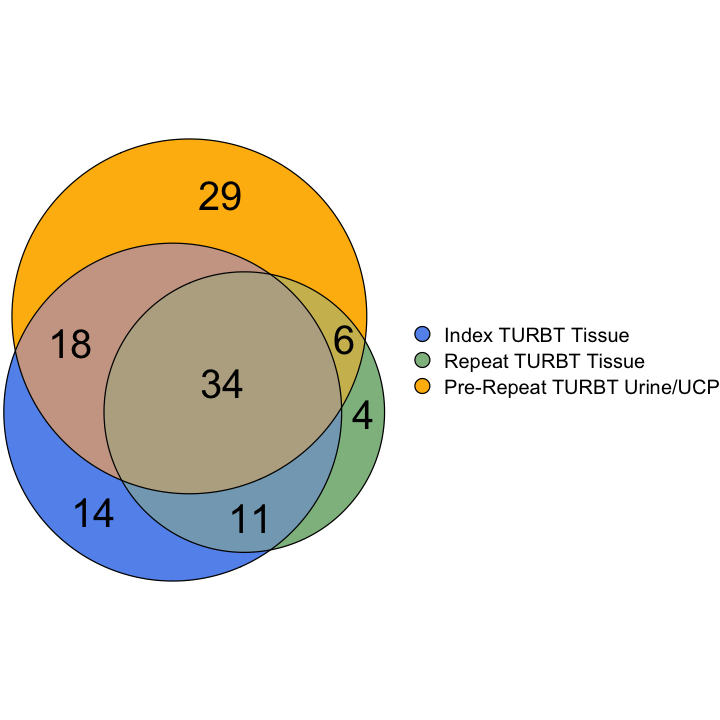

In [183]:
library(eulerr) # Unpatched

#pdf("./ASCO_GU/Venn_ATLAS_variants_12062022.pdf", width=5, height=5)
venn_variants = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short) %>%
                    distinct(SampleID.short, VariantID, .keep_all=T) %>%
                    mutate(label=paste0(PatientID, "_", VariantID))
                    
nrow(venn_variants)
index = venn_variants %>% filter(StudyVisit=="IndexTURBT")
print("index")
nrow(index)
repeat. = venn_variants %>% filter(StudyVisit=="RepeatTURBT")
print("repeat")
nrow(repeat.)
urine = venn_variants %>% filter(StudyVisit=="Pre-Repeat TURBT")
print("urine/ucp")
nrow(urine)
stopifnot(nrow(rbind(index,repeat.,urine))==nrow(venn_variants))

options(repr.plot.width=6, repr.plot.height=6)

v <- euler(list("Index TURBT Tissue"=index$label,  
             "Repeat TURBT Tissue"=repeat.$label,
             "Pre-Repeat TURBT Urine/UCP"=urine$label))
eulerr_options(padding = unit(5, "mm"))
plot(v,
     quantities = list(type = "counts", cex=2),
     #labels = list(cex=2.1),
     fills = list(fill = c("cornflowerblue", 
                           "darkseagreen", 
                           "darkgoldenrod1")
                  #alpha=0.6
                 ),
    legend = TRUE)
#dev.off()

In [19]:
unique(all.snv_atlas$SampleType)
unique(all.snv_atlas$StudyVisit)

[1] "Supernatant"       "Urine Cell Pellet" "Tissue"

[1] "Pre-Repeat TURBT" "Surveillance 1"   "Post TURBT"       "RepeatTURBT"     
[5] "IndexTURBT"


      Supernatant            Tissue Urine Cell Pellet 
                6                 7                 1 


      Supernatant            Tissue Urine Cell Pellet 
               10                11                 1 

[1] "NMIBC035"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC013"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


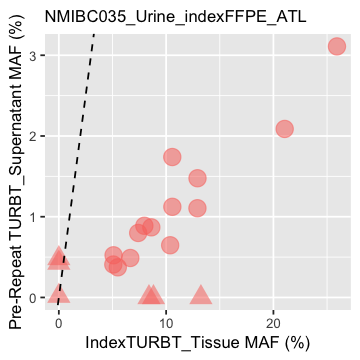

[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC005"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC016"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "WARN: No variants selected for one or both sample types."
[1] "NMIBC033"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC006"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC009"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC010"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC021"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC019"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC003"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC014"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC001"
[1] "NMIBC018"


quartz_off_screen 
                2

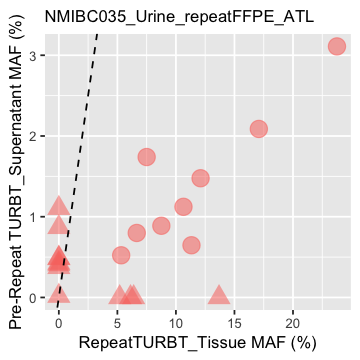

In [34]:
# MAF concordance scatters by patient prerepeat urine vs ffpe, ATLAS, unpatched ## swithch this to the MRD hotspot panel
library(gridExtra)
library(grid)
source("~/Desktop/puffin/R/compareMAFs.R")

df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(df_pre_urine$PatientID, df_repeatT$PatientID)
df_preurine_repeatT_samples = rbind(df_pre_urine, df_repeatT) %>% filter(PatientID %in% patients)
table(df_preurine_repeatT_samples$SampleType)

patients = intersect(df_pre_urine$PatientID, df_indexT$PatientID)
df_preurine_indexT_samples = rbind(df_pre_urine, df_indexT) %>% filter(PatientID %in% patients)
table(df_preurine_indexT_samples$SampleType)


plt.sz = 3
point.sz = 9
ncol = 2
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
# blank_scatter <- function(plot.title){
#     gg <- ggplot(data.frame(x=c(0,0), y=c(0,0)), aes(x=x, y=y)) + 
#            geom_point() +
#            ggtitle(plot.title) +
#             theme(plot.title=element_text(size=10), axis.text=element_blank(), axis.title=element_blank())
#     return(gg)
# }
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE
patients = unique(df_all_qc$PatientID)

# index vs. repeat
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_repeatTURBT_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_repeatTURBT_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
        
        
# urine vs index
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_Urine_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
    
    
# urine vs. repeat
plots = list()
for (pid in patients){
    plot.title=paste0(pid,"_Urine_repeatFFPE")
    if (pid %in% df_preurine_repeatT_samples$PatientID){
        samples = unlist(df_preurine_repeatT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples)%>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("RepeatTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".2")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
}
# p <- do.call("grid.arrange", c(plots, ncol=ncol))
# #options(repr.plot.width=15, repr.plot.height=5*length(patients))
# #plot(p)
# pdf("./NMIBC_MAF_scatter_by_patient_Urine_vs_FFPEs_ATL_01102023.pdf", height=(plt.sz*length(patients)), width=plt.sz*ncol)
# plot(p)
# dev.off()

# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_repeatFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()


In [36]:
all.snv_out = all.snv_unfilt %>% mutate("in.ATLAS"=(VariantID %in% all.snv_atlas$VariantID))
write.table(all.snv_out, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked.tsv", sep="\t",
            row.names=F, col.names=T, quote=F)

# write.table(all.snv, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.tsv", sep="\t",
#             row.names=F, col.names=T, quote=F)

In [147]:
get_max_concord_maf2 <- function(all_snvs_atlas, ref_sample_types, ref_study_visit, df_qc){
    stopifnot(nrow(df_qc)>0)
    sample_data = list()
    # for each patient, extract preTURB urine/ucp variants
    for (pid in unique(df_qc$PatientID)){
        print(pid)
        df_pid = df_qc %>% filter(PatientID==pid, SampleType!="Buffy Coat")
        ref_sid = df_pid %>% filter(SampleType %in% ref_sample_types, StudyVisit==ref_study_visit)
        if (nrow(ref_sid) >0){
            if (nrow(ref_sid)>1){print(paste0("WARN: more than one ref sample: ",pid))}
            ref_sid = ref_sid$SampleID.short[1]
        }else{
            print(paste0("no ref. sample. skipping: ", pid))
            next
        }
        #print(ref_sid)
        df_ref_vars = all_snvs_atlas %>% filter(SampleID.short==ref_sid)
        n_ref_vars = nrow(df_ref_vars)
        
        df_sel_samples = df_qc %>% filter(PatientID==pid)
        for (sid.short in unique(df_sel_samples$SampleID.short)){
            sample_type = df_pid %>% filter(SampleID.short==sid.short) %>% select(SampleType)
            study_visit = df_pid %>% filter(SampleID.short==sid.short) %>% select(StudyVisit)
            n_sample_vars = nrow(all_snvs_atlas %>% filter(SampleID.short==sid.short))
    
            if (n_sample_vars == 0){
                sample_concord_var = 0
                n_concord_vars = 0
            }else{
                sample_concord_var = all_snvs_atlas %>% filter(SampleID.short==sid.short, VariantID %in% df_ref_vars$VariantID)
                n_concord_vars = nrow(sample_concord_var)
            }
            
            # for finding max MAF:
#             if (nrow(sample_concord_snvs > 0){
#                 max_cMAF = max(sample_concord_snv$altDepth / sample_concord_snv$totalDepth)
#                 #var_name = sample_concord_snv[sample_concord_snv$] TODO
#             }else{
#                 max_cMAF = 0
#             }
#             sample_data[[sid.short]] <- c(n_ref_snvs, n_concord_snvs, max_cMAF, sample_type, pid)
            sample_data[[sid.short]] <- c(n_ref_vars, n_sample_vars, n_concord_vars, sample_type, study_visit, pid)
            #print(length(sample_data))
            }
        }

    df_max_mafs = do.call(rbind, sample_data)
    df_max_mafs <- cbind(rownames(df_max_mafs), data.frame(df_max_mafs, row.names=NULL))
#     names(df_max_mafs) <- c("SampleID.short","n_ref_snvs", "n_concord_snvs", "max_cMAF", "SampleType", "PatientID")
    #names(df_max_mafs) <- c("SampleID.short","n_ref_vars", "n_sample_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    names(df_max_mafs) <- c("SampleID.short","n_ref_preUrine_snvs", "n_SID_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    
    # attach cfDNA yields and collection day
    df_max_mafs2 = df_max_mafs %>% left_join(df_qc, by="SampleID.short") #%>% 
#       left_join(df_sid_to_day %>% select(-SampleType), by="SampleID.short") #%>%
      #left_join(df_qc %>% select(SampleID.short, NAYield), by="SampleID.short")
    
    #df_max_mafs2 = df_max_mafs2 %>% filter(n_ref_snvs!=0)
    #df_max_mafs2$amt_ctDNA = df_max_mafs2$NAYield * (df_max_mafs2$max_cMAF / 100) *1000
    #df_max_mafs2$log_amt_ctDNA = log(df_max_mafs2$amt_ctDNA + 1)
    
    return(df_max_mafs2)
    }

In [149]:
df_concord_counts2 = get_max_concord_maf2(all_snvs_atlas = all.snv_atlas,
                                         ref_sample_types= c("Supernatant", "Urine Cell Pellet"),
                                         ref_study_visit="Pre-Repeat TURBT",
                                         df_qc = df_all_qc) #all samples in project

df_concord_counts2

[1] "NMIBC035"
[1] "NMIBC013"
[1] "NMIBC005"
[1] "NMIBC016"
[1] "NMIBC033"
[1] "NMIBC006"
[1] "NMIBC009"
[1] "NMIBC010"
[1] "NMIBC021"
[1] "NMIBC019"
[1] "NMIBC003"
[1] "NMIBC014"
[1] "NMIBC001"
[1] "NMIBC018"


SampleID.short,n_ref_preUrine_snvs,n_SID_vars,n_concord_vars,SampleType.x,StudyVisit.x,PatientID.x,X,SampleID,Total.reads..M.,⋯,category,sampleFolder,Panel2.Target.unique.fragment.coverage,Panel2.Target.read.coverage,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,PatientID.y,externalSampleID,StudyVisit.y,Duplicated
<chr>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<int>,<chr>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
P220085,36,23,19,Tissue,IndexTURBT,NMIBC035,1,P220085,260.0,⋯,RUO,P220085_220907,200,341,58.8,59.6,NMIBC035,06S22036059,IndexTURBT,FALSE
P220086,36,22,14,Tissue,RepeatTURBT,NMIBC035,6,P220086,245.0,⋯,RUO,P220086_220907,134,226,50.8,50.6,NMIBC035,06S22052900,RepeatTURBT,FALSE
P217592,36,36,36,Supernatant,Pre-Repeat TURBT,NMIBC035,31,P217592,113.0,⋯,RUO,P217592_221014,NA,NA,NA,NA,NMIBC035,06S22034638,Pre-Repeat TURBT,FALSE
P220076,83,140,79,Tissue,IndexTURBT,NMIBC013,2,P220076,257.0,⋯,RUO,P220076_220902,198,317,57.5,58.4,NMIBC013,06S22068063,IndexTURBT,FALSE
P219771,83,83,83,Supernatant,Pre-Repeat TURBT,NMIBC013,33,P219771,108.0,⋯,RUO,P219771_221014,NA,NA,NA,NA,NMIBC013,06S22021715,Pre-Repeat TURBT,FALSE
P219778,83,54,47,Supernatant,Surveillance 1,NMIBC013,34,P219778,102.0,⋯,RUO,P219778_221014,NA,NA,NA,NA,NMIBC013,06S22049794,Surveillance 1,FALSE
P220070,22,12,9,Tissue,RepeatTURBT,NMIBC005,3,P220070,251.0,⋯,RUO,P220070_220907,169,280,47.1,47.3,NMIBC005,06S22052895,RepeatTURBT,FALSE
P220069,22,11,9,Tissue,IndexTURBT,NMIBC005,5,P220069,245.0,⋯,RUO,P220069_220907,180,339,61.5,61.0,NMIBC005,06S22035975,IndexTURBT,FALSE
P217599,22,19,9,Supernatant,Post TURBT,NMIBC005,26,P217599,126.0,⋯,RUO,P217599_221014,NA,NA,NA,NA,NMIBC005,06S22023956,Post TURBT,FALSE


In [ ]:
# MAF scatters by patient
library(gridExtra)
library(grid)

plt.sz = 3
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
blank_scatter <- function(plot.title){
    gg <- ggplot(data.frame(x=c(0,0),y=c(0,0)), aes(x=x, y=y)) + 
           geom_point() +
           ggtitle(plot.title)
    return(gg)
}
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE

patients = df_clin$PatientID
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid," urine_ffpe_WES+")
    if (pid %in% samples_paired_urine_ffpe$PatientID){
        print("urine vs. tissue")
        samples = unique(unlist(samples_paired_urine_ffpe %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_wes = all.snv_wes %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_wes, selectors=c("Cystectomy_FFPE","Pre Op_Urine"),
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".1")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_ffpe_ATLAS")
    if (pid %in% samples_paired_ffpe_plasma$PatientID){
        print("plasma vs. tissue")
        samples = unique(unlist(samples_paired_ffpe_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Cystectomy_FFPE","Pre Op_Plasma"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".2")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_urine_ATLAS")
    if (pid %in% samples_paired_urine_plasma$PatientID){
        print("urine vs. plasma")
        samples = unique(unlist(samples_paired_urine_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Pre Op_Plasma","Pre Op_Urine"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".3")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".3")]] = blank_scatter(plot.title)
    }
}

p <- do.call("grid.arrange", c(plots, ncol=3))
#options(repr.plot.width=15, repr.plot.height=5*length(patients))
#plot(p)

pdf("./MIBC_MAF_scatter_by_patient_01102023.pdf", height=plt.sz*length(patients), width=plt.sz*3)
plot(p)
dev.off()


In [ ]:
# prerepeat_pid n_variants type=unique,index_concordant,repeat_concordant ## need to make this based on percentages
# df_concord_counts_f = df_concord_counts[,1:7]
# pre_rep_counts = df_concord_counts_f %>% filter(StudyVisit.x!="Pre-Repeat TURBT")
# index_counts = df_concord_counts_f %>% filter(StudyVisit.x!="IndexTURBT")
# repeat_counts = df_concord_counts_f %>% filter(StudyVisit.x!="RepeatTURBT")

# df_plot = pre_rep_counts %>% select(PatientID.x, n_SID_vars) %>% 
#                 left_join(index_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x") %>%
#                 left_join(repeat_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x", suffix=c(".index",".repeat")) %>%
#           mutate(unique.vars)
#           pivot_longer(!PatientID.x, names_to="Variants")

# head(df_plot)

# ggplot(df_plot, aes(x=as.character(PatientID.x), y=as.numeric(value), fill=Variants)) +
#     geom_bar(stat = "identity")

## LPWGS CNB + TF analysis (urine)

In [6]:
# df_urine_pre = rbind.common(rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2), df_urine_lpwgs_b) %>% 
#     filter(StudyVisit=="Pre-Repeat TURBT") #%>% mutate(disease.positive=PatientID %in% df_wrepeat$PatientID)
# nrow(df_urine_pre)
# head(df_urine_pre)
# df = df_urine_pre %>% 
#     select(PatientID, StudyVisit, disease.positive, wgsTumorfrac_ichorCNA) %>% arrange(PatientID)
# write.csv(df, "./pre_repeat_urine_WGS_TF_list.csv", row.names=F)

[1] 43

,SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Fragment_Size_Mode,Softclip.ratio,ProjectDir,coveredGenomicPect,coverage,qcLabel,gender,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,classificationLabel,binNum,cnvbinNum,cnabinNum,cnlbinNum,cnvbinRatio,neutbinNum,neutbinRatio,wgsTumorfrac_EM,externalSampleID,SampleID.short,ExternalID,SubjectID,StudyVisit,RequisitionID,SampleType,SampleVol,DNAYield,QC,PatientID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,P219768_WGS,112.0,112.0,99.9,56.1,49.9,96,0.1560,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,91.2,1.81,Pass,male,0.0259,60.137,1843520,5.298889,lowRisk,2330,68,46,22,0.029,440,0.189,0.0000000,06S22025115,P219768,06S22025115,NMIBC021,Pre-Repeat TURBT,P219768,Urine,45,941.19000,Pass,NMIBC021
2,P219769_WGS,65.2,65.1,99.9,35.8,45.0,157,0.0764,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,91.2,1.61,Pass,male,0.3847,1139.441,1662373,10.236416,highRisk,2328,1367,598,769,0.587,893,0.384,0.6734058,06S22019729,P219769,06S22019729,NMIBC011,Pre-Repeat TURBT,P219769,Urine,45,198.34275,Pass,NMIBC011
3,P219770_WGS,79.6,78.2,98.2,47.2,39.6,171,0.0816,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,94.6,2.34,Pass,female,0.1826,596.068,2394820,9.270623,highRisk,2330,881,482,399,0.378,964,0.414,0.2087658,06S22009423,P219770,06S22009423,NMIBC003/MIBC021,Pre-Repeat TURBT,P219770,Urine,37,2940.70500,Pass,NMIBC003
4,P217594_WGS,NA,NA,NA,NA,NA,126,0.0982,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,91.4,1.89,Pass,male,0.0000,23.266,1936359,3.564916,lowRisk,2330,0,0,0,0.000,2330,1.000,0.0000000,06S22025472,P217594,06S22025472,NMIBC009,Pre-Repeat TURBT,P217594,Urine,25,1148.28750,Pass,NMIBC009
5,P217595_WGS,NA,NA,NA,NA,NA,123,0.0915,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,93.9,2.03,Pass,male,0.0000,25.616,2066406,4.023014,lowRisk,2330,0,0,0,0.000,2329,1.000,0.0000000,06S22017945,P217595,06S22017945,NMIBC019,Pre-Repeat TURBT,P217595,Urine,14,60.93225,Pass,NMIBC019
6,P217596_WGS,NA,NA,NA,NA,NA,143,0.0650,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,95.1,2.08,Pass,male,0.0000,16.653,2134340,3.318286,lowRisk,2330,0,0,0,0.000,2330,1.000,0.0000000,06S22025295,P217596,06S22025295,NMIBC016,Pre-Repeat TURBT,P217596,Urine,25,152.02800,Pass,NMIBC016


In [80]:
#options(repr.plot.width=) ## for ESMO abstract
source("~/Desktop/puffin/R/helper_functions.R")
pdf("./data_batch3_02222023/urine_tissue_lpwgs_tumor_fraction_05092023.pdf")
quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_EM"),
              x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
             plot.title="Pre-repeat Urine WGS Tumor Fraction (EM)")

quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_ichorCNA"),
              x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
             plot.title="Pre-repeat Urine WGS Tumor Fraction (ichor)")

# rerun 
# quick_boxplot(df = df_windex %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_ichorCNA"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="IndexTURBT Tissue WGS Tumor Fraction (ichor)")
dev.off()

# A tibble: 2 × 4
  disease.positive count legend       color    
  <chr>            <chr> <chr>        <chr>    
1 FALSE            21    FALSE (n=21) lightblue
2 TRUE             22    TRUE (n=22)  indianred
[1] "FALSE vs TRUE, unpaired"
FALSE mean: 3.57142857142857
TRUE mean: 9.04545454545454

	Wilcoxon rank sum test with continuity correction

data:  df_lev1 and df_not_lev1
W = 117, p-value = 0.003048
alternative hypothesis: true location shift is not equal to 0

  disease.positive WGS.Tumor.Fraction   label
1            FALSE                 22 p=0.003
2             TRUE                 NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


# A tibble: 2 × 4
  disease.positive count legend       color    
  <chr>            <chr> <chr>        <chr>    
1 FALSE            21    FALSE (n=21) lightblue
2 TRUE             22    TRUE (n=22)  indianred
[1] "FALSE vs TRUE, unpaired"
FALSE mean: 4.9047619047619
TRUE mean: 12.2272727272727

	Wilcoxon rank sum test with continuity correction

data:  df_lev1 and df_not_lev1
W = 109.5, p-value = 0.002406
alternative hypothesis: true location shift is not equal to 0

  disease.positive WGS.Tumor.Fraction   label
1            FALSE                 26 p=0.002
2             TRUE                 NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


pdf 
  2

[1] TRUE
[1] TRUE
[1] 43
number of NA labels: 0
[1] "case/control: 22 / 21"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1    0.0218   0.7142857   0.8181818
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.762987012987013"


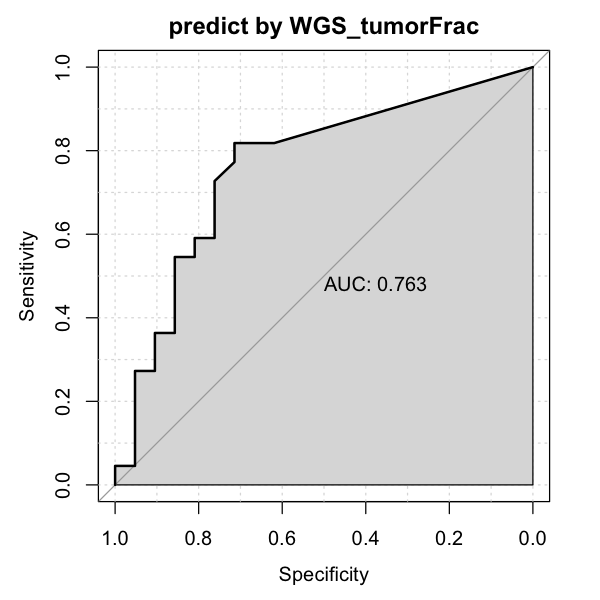

In [79]:
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, target_sens=NA){
    print(label_col %in% names(df))
    print(score_col %in% names(df))
    print(sum(!is.na(df[[score_col]])))
    df = df %>% rename("label"={{label_col}}, "score"={{score_col}}) %>% mutate("label"=as.character(label))
    print(glue("number of NA labels: {sum(is.na(df$label))}"))
    print(sprintf("case/control: %s / %s", sum(df$label=="TRUE"), sum(df$label=="FALSE")))
    
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(label=="TRUE", score >= thresh))
      FN = nrow(df %>% filter(label=="TRUE", score < thresh))
      TN = nrow(df %>% filter(label=="FALSE", score < thresh))
      FP = nrow(df %>% filter(label=="FALSE", score >= thresh))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    
    pROC_obj <- roc_(data=df, response="label", 
                predictor="score", smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE, main=title)
    }
    print(coords(pROC_obj, x="best"))
    
    if (!is.na(target_sens)){
        print(sprintf("target sens %s", target_sens))
        print(coords(pROC_obj, x=target_sens, input="sensitivity", 
                     ret=c("threshold","specificity", "sensitivity")))
        }
    print(paste0("AUC: ", auc(pROC_obj)))
}
# for ESMO abstract
get_sens_spec(df_urine_pre, "disease.positive", "wgsTumorfrac_ichorCNA", target_sens=1.0, title="predict by WGS_tumorFrac")

In [51]:
## selection table for WES+
# check patient treatment and expected followup samples with MCC
source("~/Desktop/puffin/R/helper_functions.R")
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

df_urine_post = df_lpwgs_all %>% filter(SampleType == "Urine", 
                                        StudyVisit!="Pre-Repeat TURBT")
nrow(df_urine_post)
df_pbmc_all = df_wes_qc.all %>% filter(SampleType %in% c("PBMC", "Buffy Coat", "Buffy_Coat"))
nrow(df_pbmc_all)
df_preurine_summary = standardize_names(df_lpwgs_all, "samples") %>% filter(SampleType=="Urine", StudyVisit=="Pre-Repeat TURBT")

# did we do lpwgs for these batch 1 samples? lpwgs data missing
ss = df_wes_qc1.urine_pbmc %>% filter(Specimen_type=="Supernatant")

df_preurine_summary = df_preurine_summary %>%
                                left_join(df_clin %>% select(PatientID, Sex, Index.Stage, Repeat.Stage, disease.positive), by="PatientID") %>%
                                mutate(has.germ = PatientID %in% df_pbmc_all$PatientID,
                                       n.followup.urines = (lapply(PatientID, function(x) sum(df_urine_post$PatientID == x))),
                                       WES.completed=SampleID.short %in% ss$SampleID)
                                                                                         
df_concord = get_concordance_stats(variant.data = all.snv, ref_sample_type = "IndexTURBT_Tissue", 
                                        df_samples = df_wes_qc.all)

df_preurine_summary = df_preurine_summary %>% left_join(df_concord %>% filter(StudyVisit=="IndexTURBT"), by="PatientID") %>%
                                              left_join(df_concord %>% filter(StudyVisit=="RepeatTURBT"), by="PatientID",
                                                           suffix=c(".index",".repeat")) %>%
                                              left_join(df_concord %>% filter(StudyVisit=="Pre-Repeat TURBT") %>% 
                                                                        select(PatientID,n_sample_vars,n_concord_vars), by="PatientID") %>%
                                              left_join(df_qc_all, by="SampleID.short", suffix=c(".",".qc")) %>%
                                              left_join(df_wes_qc2.all %>% select(SampleID.short, library_yield_ug), by="SampleID.short", suffix=c(".",".ngsqc"))
df_preurine_summary$MRD.completed = (df_preurine_summary$SampleID.short.x %in% mrd.table$SampleID.short)
stopifnot(all(!duplicated(df_preurine_summary$SampleID.short.x)))      
                                                            
write.csv(df_preurine_summary %>% mutate(across(everything(),as.character)) %>%
                                  relocate(PatientID., SampleID.short.x, SampleType.x, StudyVisit.x, DNAYield, library_yield_ug, 
                                           wgsTumorfrac_ichorCNA, wgsTumorfrac_EM, cnbScore, 
                                           Sex, Index.Stage, Repeat.Stage, disease.positive, has.germ, n.followup.urines, WES.completed, MRD.completed, 
                                           n_sample_vars.index, n_sample_vars.repeat, n_concord_vars.repeat, pct.concord.repeat),
          "./prerepeat_urine_wes_selection_table_05192023.csv", row.names=F) # refine in excel                                              

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

[1] 41

[1] 46

[1] "Pre-Repeat TURBT" "IndexTURBT"       "RepeatTURBT"     
[1] "PBMC"   "Urine"  "Tissue"
[1] "WARN: No ref. sample for: NMIBC006"
[1] "WARN: No ref. sample for: NMIBC018"
[1] "WARN: No ref. sample for: NMIBC001"
[1] "WARN: No ref. sample for: NMIBC011"
[1] "WARN: No ref. sample for: 174947"
[1] "WARN: No ref. sample for: 173281"
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 154"
[1] "min: 0"
[1] "max: 1392"
[1] "sd: 303.474386873707"
[1] "MRD sample: Pre-Repeat TURBT_Urine" "MRD sample: RepeatTURBT_Tissue"    
[1] "median number MRD variants: 42.5"
[1] "min: 0"
[1] "max: 1113"
[1] "sd: 203.173380293514"


In [22]:
pid.table = read.csv("./MCC_patientID_key_LT_06292023.csv", as.is=T)
oldpid_to_newpid = pid.table$New.patient.ID
names(oldpid_to_newpid) <- pid.table$Old.patient.ID

ngsqc.batch1 = read.csv("data_batch1_and_2/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-09-23_urine_ucp_pbmc_ffpe.csv")
ngsqc.batch3 = read.csv("data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-05-03.csv")
ngsqc.subset.of.1n3 = read.csv("batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_NGSQC_all_plusPBMCs_2023-06-29.csv")

all.seq.samples.ngsqc = rbind.common(rbind.common(ngsqc.batch1, ngsqc.batch3), 
                                     ngsqc.subset.of.1n3) %>% distinct(SampleID, .keep_all=TRUE)
                  
all.seq.samples.ngsqc = all.seq.samples.ngsqc %>%
              mutate(PatientID.old=PatientID,
                     PatientID.new=recode(as.character(all.seq.samples.ngsqc$PatientID), !!!oldpid_to_newpid, .default=NA),
                     PatientID=ifelse(is.na(PatientID.new), PatientID.old, PatientID.new))
unique(all.seq.samples.ngsqc$PatientID)
head(all.seq.samples.ngsqc)
write.csv(all.seq.samples.ngsqc %>% 
                  filter(!grepl("buffy", Specimen_type, ignore.case=T)) %>% 
                  mutate(across(everything(), as.character)),
          "./NGSQC_All_non_buffy_07062023.csv", row.names=F)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `PatientID.new = recode(...)`.
Caused by warning:
! Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`.”


,PatientID,externalSampleID,trialVisitNum,Specimen_type,Panel,SampleID,QC_Status,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,⋯,pversion,category,sampleFolder,Panel2.Target.unique.fragment.coverage,Panel2.Target.read.coverage,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,Duplicated,PatientID.old,PatientID.new
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,173983,06S22042167,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P217584,Pass,119,119,99.8,⋯,1.7.0,RUO,P217584_220913,92,151,76.8,75.4,FALSE,NMIBC035,173983
2,172586,06S22042774,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P217583,Pass,109,109,99.8,⋯,1.7.0,RUO,P217583_220913,86,140,75.0,73.6,FALSE,NMIBC005,172586
3,169558,06S22041062,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P217586,Pass,107,107,99.8,⋯,1.7.0,RUO,P217586_220913,86,142,70.9,69.9,FALSE,NMIBC009,169558
4,172851,06S22042535,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P217582,Pass,106,106,99.8,⋯,1.7.0,RUO,P217582_220913,81,129,73.4,72.1,FALSE,NMIBC010,172851
5,171374,06S21164700,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P219807,Pass,106,106,99.8,⋯,1.7.0,RUO,P219807_220907,91,140,72.2,72.0,FALSE,NMIBC001,171374
6,172602,06S22042541,Pre-Repeat TURBT,Buffy Coat,PREDICINEWES_V1,P217581,Pass,105,105,99.8,⋯,1.7.0,RUO,P217581_220913,83,133,74.5,72.9,FALSE,NMIBC006,172602
